In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option('display.float_format', lambda x: '%.6f' % x)

# Evaluation of Converge-A cost function in quality alignment-score mode

The following notebook examines the clustering quality of the different variants of the Converge-A cost function when running GeFaST in quality alignment-score mode.
The evaluation uses the results on the Callahan data sets and on the Franzén data sets:
 - Callahan et al., *DADA2: High-resolution sample inference from Illumina amplicon data* (https://doi.org/10.1038/nmeth.3869)
 - Franzén et al., *Improved OTU-picking using long-read 16S rRNA gene amplicon sequencing and generic hierarchical clustering* (https://doi.org/10.1186/s40168-015-0105-6)
 
This evaluation relies on the CSV outputs of the notebooks of the evaluations specific to the different tools and data sets.
The required files are listed below.
The variant considered best is included in the overall evaluation of the quality-weighted clustering methods in `quality_weighted_overall.ipynb`.
 
### GeFaST variants
GeFaST is evaluated in alignment-score mode (as a reference) and in quality alignment-score mode using the Converge-A cost function with different boosting functions (`linear`, `mult`, `root`).

The different (quality-weighted) variants are usually referred to by an abbreviation hinting at the mode, quality-weighting technique and boosting function (including parameters): `<variant>_<boosting>_qas-ca`, e.g. `mw_unboosted_qas-ca` and `v1_root2_qas-ca`.
The completely unweighted variant in alignment-score mode is denoted as `original_as`.

Values of `<variant>`:

| Abbreviation | Description |
| --: | :-- |
| muw | matches in an alignment are *not* quality-weighted, unboosted variant |
| mw  | matches in an alignment are quality-weighted, unboosted variant |
| v1  | matches in an alignment are quality-weighted, inner boosting |
| v2  | matches in an alignment are *not* quality-weighted, inner boosting |
| v3  | matches in an alignment are quality-weighted, outer boosting |
| v4  | matches in an alignment are *not* quality-weighted, outer boosting |

Values of `<boosting>`:

| Abbreviation | Description |
| --: | :-- |
| unboosted    | unboosted variant |
| linear*x*    | linear boosting starting at `linear_start` = *x*  |
| mult*x*      | multiplicative boosting with `mult_factor` = *x* |
| root*x*      | unshifted root boosting with `root_degree` = *x* |
| rootshift*x* | shifted root boosting with `root_degree` = *x* and `root_shift` = *full* |


### USEARCH & VSEARCH variants
As further references, USEARCH is evaluated for the `cluster_fast` command with the option `-sort size`,
while VSEARCH is included in the variant using the `cluster_size` command. 

In [ ]:
# Required files:
#
# analyses
# |- quality_weighted_callahan  # evaluation of GeFaST's quality-weighted clustering methods on Callahan data
# |  \- evaluation
# |     |- df_joined_max_avg.csv
# |     |- df_joined_mean_avg.csv
# |     |- df_joined_nbest_avg.csv
# |     |- df_max_lvls.csv
# |     |- df_mean_lvls.csv
# |     \- df_nbest_lvls.csv
# |
# |- quality_weighted_franzen  # evaluation of GeFaST's quality-weighted clustering methods on Franzén data
# |  \- evaluation
# |     |- df_joined_max_avg.csv
# |     |- df_joined_mean_avg.csv
# |     |- df_joined_nbest_avg.csv
# |     |- df_max_lvls.csv
# |     |- df_mean_lvls.csv
# |     \- df_nbest_lvls.csv
# |
# |- uvsearch_callahan  # evaluation of USEARCH and VSEARCH on Callahan data
# |  \- evaluation
# |     |- df_joined_max_avg.csv
# |     |- df_joined_mean_avg.csv
# |     \- df_joined_nbest_avg.csv
# |
# \- uvsearch_franzen  # evaluation of USEARCH and VSEARCH on Franzén data
#    \- evaluation
#       |- df_joined_max_avg.csv
#       |- df_joined_mean_avg.csv
#       \- df_joined_nbest_avg.csv

**Configuration**

In [2]:
qw_option = 'ca'          # quality-weighted cost function
mode = 'as'               # quality-unweighted mode
qmode = 'qas'             # quality-weighted mode

rename_map = {'adjrandindex': 'Adjusted Rand index', 'precision': 'Precision', 'recall': 'Recall'}

### Load the evaluation data

**GeFaST**

In [3]:
# Callahan data sets
callahan_gefast_dir = '../quality_weighted_callahan/evaluation'
df_callahan_gefast_joined_max_avg = pd.read_csv('%s/df_joined_max_avg.csv' % callahan_gefast_dir, sep = ';')
df_callahan_gefast_joined_mean_avg = pd.read_csv('%s/df_joined_mean_avg.csv' % callahan_gefast_dir, sep = ';')
df_callahan_gefast_joined_nbest_avg = pd.read_csv('%s/df_joined_nbest_avg.csv' % callahan_gefast_dir, sep = ';')
df_callahan_gefast_max_lvls = pd.read_csv('%s/df_max_lvls.csv' % callahan_gefast_dir, sep = ';')
df_callahan_gefast_mean_lvls = pd.read_csv('%s/df_mean_lvls.csv' % callahan_gefast_dir, sep = ';')
df_callahan_gefast_nbest_lvls = pd.read_csv('%s/df_nbest_lvls.csv' % callahan_gefast_dir, sep = ';')

# Franzén data sets
franzen_gefast_dir = '../quality_weighted_franzen/evaluation'
df_franzen_gefast_joined_max_avg = pd.read_csv('%s/df_joined_max_avg.csv' % franzen_gefast_dir, sep = ';')
df_franzen_gefast_joined_mean_avg = pd.read_csv('%s/df_joined_mean_avg.csv' % franzen_gefast_dir, sep = ';')
df_franzen_gefast_joined_nbest_avg = pd.read_csv('%s/df_joined_nbest_avg.csv' % franzen_gefast_dir, sep = ';')
df_franzen_gefast_max_lvls = pd.read_csv('%s/df_max_lvls.csv' % franzen_gefast_dir, sep = ';')
df_franzen_gefast_mean_lvls = pd.read_csv('%s/df_mean_lvls.csv' % franzen_gefast_dir, sep = ';')
df_franzen_gefast_nbest_lvls = pd.read_csv('%s/df_nbest_lvls.csv' % franzen_gefast_dir, sep = ';')

**USEARCH / VSEARCH**

In [4]:
# Callahan data sets
callahan_uvsearch_dir = '../uvsearch_callahan/evaluation'
df_callahan_uvsearch_joined_max_avg = pd.read_csv('%s/df_joined_max_avg.csv' % callahan_uvsearch_dir, sep = ';')
df_callahan_uvsearch_joined_mean_avg = pd.read_csv('%s/df_joined_mean_avg.csv' % callahan_uvsearch_dir, sep = ';')
df_callahan_uvsearch_joined_nbest_avg = pd.read_csv('%s/df_joined_nbest_avg.csv' % callahan_uvsearch_dir, sep = ';')

# Franzén data sets
franzen_uvsearch_dir = '../uvsearch_franzen/evaluation'
df_franzen_uvsearch_joined_max_avg = pd.read_csv('%s/df_joined_max_avg.csv' % franzen_uvsearch_dir, sep = ';')
df_franzen_uvsearch_joined_mean_avg = pd.read_csv('%s/df_joined_mean_avg.csv' % franzen_uvsearch_dir, sep = ';')
df_franzen_uvsearch_joined_nbest_avg = pd.read_csv('%s/df_joined_nbest_avg.csv' % franzen_uvsearch_dir, sep = ';')

## Clustering quality

Comparison of the clustering quality (adjusted Rand index (ARI), precision, recall) of the different tools / modes / refinement options on the different data sets.
For the Franzén data, the 10 data sets of each combination of complexity (e.g. LC) and region (e.g. V4) were averaged.

Considers the clustering quality in three different ways:   
1) *Maximum*: ARI / precision / recall of the respective run (threshold) with the highest ARI on that data set (peak performance).   
2) *Average*: Average ARI / precision / recall over all runs (thresholds) on that data set (robustness of performance). Indicates how sensitive the clustering quality is to not choosing the 'optimal' threshold.   
3) *N-best average*: Average ARI / precision / recall over the respective 5 runs (thresholds) with the highest ARI on that data set (mix of peak performance and robustness of performance). Ignores the worst results for thresholds that are way off but still considers not just the optimal threshold choice.


In [5]:
def avg_diff_multiple(portions, ref, cmps, metric = 'adjrandindex'):
    
    ref_mode, ref_v, ref_qw, ref_b, ref_bp = ref
    
    df_columns = ['data_group'] + ['%s / %s / %s / %s / %s' % (m, v, q, b, bp) for m, v, q, b, bp in cmps]
    
    rows = []
    for df, data_set_groups, gt in portions:
        for (name, dsg) in data_set_groups:            
            ref_grp = df.loc[df['data_set'].isin(dsg) & (df['gt'] == gt) & (df['mode'] == ref_mode) & (df['v_opt'] == ref_v) & (df['qw_opt'] == ref_qw) & (df['b_opt'] == ref_b) & (df['b_param'] == ref_bp)]
            
            row = [name]
            for mode, v, qw, b, bp in cmps:
                cmp_grp = df.loc[df['data_set'].isin(dsg) & (df['gt'] == gt) & (df['mode'] == mode) & (df['v_opt'] == v) & (df['qw_opt'] == qw) & (df['b_opt'] == b) & (df['b_param'] == bp)]
                
                row.append(cmp_grp[metric].mean() - ref_grp[metric].mean())
            
            rows.append(row)
            
    return pd.DataFrame(rows, columns = df_columns)

-- *Maximum clustering quality*

In [6]:
for m in ['adjrandindex', 'precision', 'recall']:
    print('%s:' % rename_map[m])
    display(avg_diff_multiple([(df_franzen_gefast_joined_max_avg, [('V3-V4', ['LC_V3-V4', 'MC_V3-V4', 'HC_V3-V4']), ('V4', ['LC_V4', 'MC_V4', 'HC_V4'])], 'franzen'),
                               (df_callahan_gefast_joined_max_avg, [('paired', ['balanced_paired', 'hmp_paired']), ('single', ['balanced_single', 'hmp_single'])], 'callahan')], 
                              (mode, 'none', 'none', 'none', 'none'), [(qmode, 'muw', qw_option, 'unboosted', 'none'), (qmode, 'mw', qw_option, 'unboosted', 'none')], metric = m))

Adjusted Rand index:


,data_group,qas / muw / ca / unboosted / none,qas / mw / ca / unboosted / none
0,V3-V4,0.004272,-0.027281
1,V4,0.000057,0.003193
2,paired,0.000000,-0.001047
3,single,0.000000,-0.018034


Precision:


,data_group,qas / muw / ca / unboosted / none,qas / mw / ca / unboosted / none
0,V3-V4,0.025405,0.047618
1,V4,-0.000061,0.001486
2,paired,0.000000,0.000132
3,single,0.000000,-0.025917


Recall:


,data_group,qas / muw / ca / unboosted / none,qas / mw / ca / unboosted / none
0,V3-V4,-0.033355,-0.092298
1,V4,0.000113,0.002776
2,paired,0.000000,-0.000478
3,single,0.000000,0.004459


-- *Average clustering quality*

In [7]:
for m in ['adjrandindex', 'precision', 'recall']:
    print('%s:' % rename_map[m])
    display(avg_diff_multiple([(df_franzen_gefast_joined_mean_avg, [('V3-V4', ['LC_V3-V4', 'MC_V3-V4', 'HC_V3-V4']), ('V4', ['LC_V4', 'MC_V4', 'HC_V4'])], 'franzen'),
                               (df_callahan_gefast_joined_mean_avg, [('paired', ['balanced_paired', 'hmp_paired']), ('single', ['balanced_single', 'hmp_single'])], 'callahan')], 
                              (mode, 'none', 'none', 'none', 'none'), [(qmode, 'muw', qw_option, 'unboosted', 'none'), (qmode, 'mw', qw_option, 'unboosted', 'none')], metric = m))

Adjusted Rand index:


,data_group,qas / muw / ca / unboosted / none,qas / mw / ca / unboosted / none
0,V3-V4,0.020728,-0.139099
1,V4,-0.000666,-0.056522
2,paired,0.000000,0.000101
3,single,-0.000017,0.002999


Precision:


,data_group,qas / muw / ca / unboosted / none,qas / mw / ca / unboosted / none
0,V3-V4,-0.006161,0.041809
1,V4,-0.000609,0.034455
2,paired,0.000000,0.001718
3,single,-0.000014,0.004635


Recall:


,data_group,qas / muw / ca / unboosted / none,qas / mw / ca / unboosted / none
0,V3-V4,0.028579,-0.189274
1,V4,0.000056,-0.093180
2,paired,0.000000,-0.000183
3,single,0.000004,-0.004078


-- *N-best average clustering quality*

In [8]:
for m in ['adjrandindex', 'precision', 'recall']:
    print('%s:' % rename_map[m])
    display(avg_diff_multiple([(df_franzen_gefast_joined_nbest_avg, [('V3-V4', ['LC_V3-V4', 'MC_V3-V4', 'HC_V3-V4']), ('V4', ['LC_V4', 'MC_V4', 'HC_V4'])], 'franzen'),
                               (df_callahan_gefast_joined_nbest_avg, [('paired', ['balanced_paired', 'hmp_paired']), ('single', ['balanced_single', 'hmp_single'])], 'callahan')], 
                              (mode, 'none', 'none', 'none', 'none'), [(qmode, 'muw', qw_option, 'unboosted', 'none'), (qmode, 'mw', qw_option, 'unboosted', 'none')], metric = m))

Adjusted Rand index:


,data_group,qas / muw / ca / unboosted / none,qas / mw / ca / unboosted / none
0,V3-V4,0.038110,-0.187425
1,V4,-0.000082,-0.003176
2,paired,0.000000,-0.001165
3,single,0.000000,-0.006780


Precision:


,data_group,qas / muw / ca / unboosted / none,qas / mw / ca / unboosted / none
0,V3-V4,-0.011887,0.066192
1,V4,-0.000228,-0.003060
2,paired,0.000000,0.000136
3,single,0.000000,0.002693


Recall:


,data_group,qas / muw / ca / unboosted / none,qas / mw / ca / unboosted / none
0,V3-V4,0.053637,-0.256207
1,V4,0.000195,0.000533
2,paired,0.000000,-0.000398
3,single,0.000000,-0.010599


`muw` usually better and more robust than `mw` and `original_as` in terms of ARI.

In [9]:
best_ub = 'muw'

### Comparison of boosted quality-weighted cost function with unweighted mode

Compares the quality alignment-score mode, using a large variety of boosted variants of the Converge-A cost function (differing in the boosting function, the boosting parameters and the weighting of matches), with the alignment-score mode and among each other to determine the best boosted variant.

In [10]:
def comparative_plot(portions, metric, modes, 
                     select_metric = None, qw_opts = ['c', 'ca', 'cb', 'f', 'ka', 'kb', 'ma', 'mb', 'mc'], 
                     usearch_opt = 'fast_size', vsearch_opt = 'size', dada2_opt = 'non-chimeric', 
                     fs = (30, 10), plot_file = None):

    ratios = [len(p[4]) for p in portions]
    
    colour_palette_a = sb.color_palette('Paired')
    colour_palette_b = sb.color_palette('tab20b')
    colours = {'usearch': colour_palette_a[1], 'vsearch': colour_palette_a[5], 'dada2': colour_palette_a[11], 
               'c': colour_palette_b[8], 'ca': colour_palette_b[4], 'cb': colour_palette_b[6], 'f': colour_palette_b[16], 'ka': colour_palette_b[0], 'kb': colour_palette_b[2], 'ma': colour_palette_b[12], 'mb': colour_palette_b[14], 'mc': colour_palette_b[15]
              }
    markers = {'usearch': 'x', 'vsearch' : 'x', 'gefast_ds_opt': '_', 'gefast_all_opt': 'D'}
    marker_size = 55
    width = 0.8
    
    label_map = {'precision': 'Precision', 'recall': 'Recall', 'adjrandindex': 'Adjusted Rand index', 
                 'fast_size': 'fast / size', 'size': 'size', 'as': 'as', 'qas': 'qas', 'lev': 'lev', 'qlev': 'qlev', 
                 'c': 'Clement', 'ca': 'Converge-A', 'cb': 'Converge-B', 'f': 'Frith',
                 'ka': 'Kim-A', 'kb': 'Kim-B', 'ma': 'Malde-A', 'mb': 'Malde-B', 'mc': 'Malde-C'}
    xticklabel_size = 15
    yticklabel_size = 15
    xlabel_size = 20
    ylabel_size = 20
    
    mode, qmode = modes
    
    
    sb.set_style('white')
    fig, axes = plt.subplots(nrows = 1, ncols = len(portions), figsize = fs, sharey = True, gridspec_kw = {'width_ratios' : ratios})
    
    legend_markers = []
    legend_labels = []
    
    # Modes (colours)
    legend_markers.append(plt.Line2D([0,0],[0,0], marker = '', mew = 0.3, linestyle = ''))
    legend_labels.append('Tool  (mode)')
    
    legend_markers.append(plt.Line2D([0,0],[0,0], markeredgecolor = colours['usearch'], marker = markers['usearch'], markerfacecolor = colours['usearch'], mew = 1.0, linestyle = ''))
    legend_labels.append('USEARCH (%s)' % label_map[usearch_opt])
    
    legend_markers.append(plt.Line2D([0,0],[0,0], markeredgecolor = colours['vsearch'], marker = markers['vsearch'], markerfacecolor = colours['vsearch'], mew = 1.0, linestyle = ''))
    legend_labels.append('VSEARCH (%s)' % label_map[vsearch_opt])
    
    legend_markers.append(plt.Line2D([0,0],[1,0], marker = '', color = 'black', mew = 0.3, linestyle = ':'))
    legend_labels.append('GeFaST (%s)' % label_map[mode]) 
    
    for _ in range(0, len(qw_opts) - 1):
        legend_markers.append(plt.Line2D([0,0],[0,0], marker = '', mew = 0.3, linestyle = ''))
        legend_labels.append('')  
    
    legend_markers.append(plt.Line2D([0,0],[0,0], marker = '', mew = 0.3, linestyle = ''))
    legend_labels.append('GeFaST  (%s) with q.w.' % qmode)
    for qw in qw_opts:
        legend_markers.append(plt.Line2D([0,0],[0,0], markeredgecolor = colours[qw], marker = 'o', markerfacecolor = colours[qw], mew = 0.3, linestyle = ''))
        legend_labels.append(label_map[qw])
    legend_markers.append(plt.Line2D([0,0],[0,0], markeredgecolor = 'black', marker = markers['gefast_ds_opt'], markerfacecolor = 'none', mew = 1.0, linestyle = ''))
    legend_labels.append('Data-set best')
    legend_markers.append(plt.Line2D([0,0],[0,0], markeredgecolor = 'black', marker = markers['gefast_all_opt'], markerfacecolor = 'none', mew = 1.0, linestyle = ''))
    legend_labels.append('Read-type best')

    smetric = select_metric if select_metric is not None else metric
    
    table_rows = []
    
    for i, (name, dfg, dfuv, gt, data_sets) in enumerate(portions):
        ax = axes if (len(portions) == 1) else axes[i]
        
        df_gefast = dfg.loc[dfg['mode'].isin(modes) & (dfg['gt'] == gt) & (dfg['level'] == 'qvbb')]
        df_usearch = dfuv.loc[(dfuv['tool'] == 'usearch') & (dfuv['mode'] == usearch_opt)]
        df_vsearch = dfuv.loc[(dfuv['tool'] == 'vsearch') & (dfuv['mode'] == vsearch_opt)]
        
        xtick_labels = data_sets
        xticks = range(0, len(xtick_labels))
        xlabel = name
        
        for pos, ds in enumerate(data_sets):
            grp_gefast = df_gefast.loc[df_gefast['data_set'] == ds]
            grp_gefast_all = df_gefast.loc[df_gefast['data_set'] == 'all_%s' % ds.split('_')[1]]
            grp_usearch = df_usearch.loc[df_usearch['data_set'] == ds]
            grp_vsearch = df_vsearch.loc[df_vsearch['data_set'] == ds]
            
            step = (width / (len(qw_opts) - 1)) if len(qw_opts) > 1 else 0.1
        
            # plot USEARCH
            ax.scatter([pos - 1.5 * step] * len(grp_usearch), grp_usearch[metric], color = colours['usearch'], marker = markers['usearch'], s = marker_size, label = 'USEARCH (%s)' % usearch_opt)
        
            # plot VSEARCH
            ax.scatter([pos + 1.5 * step] * len(grp_vsearch), grp_vsearch[metric], color = colours['vsearch'], marker = markers['vsearch'], s = marker_size, label = 'VSEARCH (%s)' % vsearch_opt)
        
            # plot GeFaST
            ref_val = grp_gefast.loc[grp_gefast['mode'] == mode, metric].iloc[0] # from quality-unweighted mode
            ax.hlines(y = ref_val, xmin = pos - 0.5, xmax = pos + 0.5, linestyle = ':', alpha = 0.8) # quality-unweighted reference line            
            for k, qw in enumerate(qw_opts):
                grp = grp_gefast.loc[grp_gefast['qw_opt'] == qw]
                
                best_all = grp_gefast_all.loc[grp_gefast_all['qw_opt'] == qw].nlargest(1, smetric)
                all_v_opt = best_all['v_opt'].iloc[0]
                all_b_opt = best_all['b_opt'].iloc[0]
                all_b_param = best_all['b_param'].iloc[0]
                
                best_ds = grp.nlargest(1, smetric)
                
                best_ds_val = best_ds[metric].iloc[0]
                best_all_val = grp.loc[(grp['v_opt'] == all_v_opt) & (grp['b_opt'] == all_b_opt) & (grp['b_param'] == all_b_param), metric].iloc[0]
                
                
                ax.scatter(pos - width / 2 + k * step, best_ds_val, color = colours[qw], marker = markers['gefast_ds_opt'], s = marker_size)
                ax.scatter(pos - width / 2 + k * step, best_all_val, color = colours[qw], marker = markers['gefast_all_opt'], s = marker_size, facecolors = 'none')
                
                
                table_rows.append([ds, qw, 
                                   '%s;   %f' % (mode, ref_val), 
                                   '%s / %s / %s;   %s%f' % (all_v_opt, all_b_opt, all_b_param, '+' if best_all_val > ref_val else '', best_all_val - ref_val), 
                                   '%s / %s / %s;   %s%f' % (grp.nlargest(1, smetric)['v_opt'].iloc[0], grp.nlargest(1, smetric)['b_opt'].iloc[0], grp.nlargest(1, smetric)['b_param'].iloc[0], '+' if best_ds_val > ref_val else '', best_ds_val - ref_val)])

        ax.set_xlim(-0.5, len(data_sets) - 0.5)
        
        ax.set_xticks([-0.5], minor = False)
        ax.set_xticklabels([''], minor = False)
        ax.tick_params(axis = 'x', which = 'major', direction = 'out', length = 40, color = 'black' if i > 0 else 'white', pad = -15)
        
        ax.set_xticks(xticks, minor = True)
        ax.set_xticklabels(xtick_labels, fontsize = xticklabel_size, minor = True)
        ax.tick_params(axis = 'x', which = 'minor', direction = 'out', length = 5, color = 'black')
        
        ax.tick_params(axis = 'y', which = 'major', labelsize = yticklabel_size)
        
        ax.tick_params(which = 'major', left = (i == 0))
        ax.tick_params(which = 'both', bottom = True)
        
        ax.grid(True)
        
        ax.set_xlabel(xlabel, fontsize = xlabel_size)
        if i == 0:
            ax.set_ylabel(label_map[metric], fontsize = ylabel_size)
        
        
        for pos in range(0, len(data_sets) - 1):
            ax.axvline(pos + 0.5, color = 'lightgray', zorder = 3)
        if i > 0:
            ax.axvline(-0.5, color = 'black', zorder = 3)
            
        
    plt.subplots_adjust(wspace = 0)
    
    axes[0].legend(legend_markers, legend_labels, fontsize = 10, markerscale = 1, ncol = 2, loc = 'lower left')

    if plot_file is not None:
        plt.savefig(plot_file, format = 'pdf', dpi = 1200, bbox_inches = 'tight')
        
    return pd.DataFrame(table_rows, columns = ['data_set', 'qw_opt', '%s_baseline' % mode, 'read_type_best', 'data_set_best'])

*Column descriptions:*   
`as_baseline`: ARI of alignment-score mode   
`read_type_best`: ARI of variant that attained the highest clustering quality over all data sets of the respective read type (V3-V4, V4, paired, single)   
`data_set_best`: ARI of variant that attained the highest clustering quality on that particular data set (e.g. LC_V4)

-- *Maximum clustering quality*

,data_set,qw_opt,as_baseline,read_type_best,data_set_best
8,HC_V3-V4,ca,as; 0.526475,v4 / mult / 15; +0.046677,v4 / mult / 15; +0.046677
9,HC_V4,ca,as; 0.485187,v4 / root / 4; +0.027604,v4 / root / 5; +0.034499
4,LC_V3-V4,ca,as; 0.813486,v4 / mult / 15; +0.042005,v4 / mult / 10; +0.043585
5,LC_V4,ca,as; 0.830749,v4 / root / 4; +0.016940,v4 / root / 4; +0.016940
6,MC_V3-V4,ca,as; 0.702338,v4 / mult / 15; +0.044423,v4 / mult / 15; +0.044423
7,MC_V4,ca,as; 0.691493,v4 / root / 4; +0.022983,v4 / rootshift / 6; +0.023112
1,balanced_paired,ca,as; 0.950865,v4 / root / 6; +0.007935,v2 / root / 10; +0.008160
0,balanced_single,ca,as; 0.941401,v4 / mult / 1000; +0.000053,v4 / mult / 1000; +0.000053
3,hmp_paired,ca,as; 0.749073,v4 / root / 6; +0.000582,v4 / mult / 50; +0.000600
2,hmp_single,ca,as; 0.909730,v4 / mult / 1000; +0.000406,v4 / mult / 1000; +0.000406


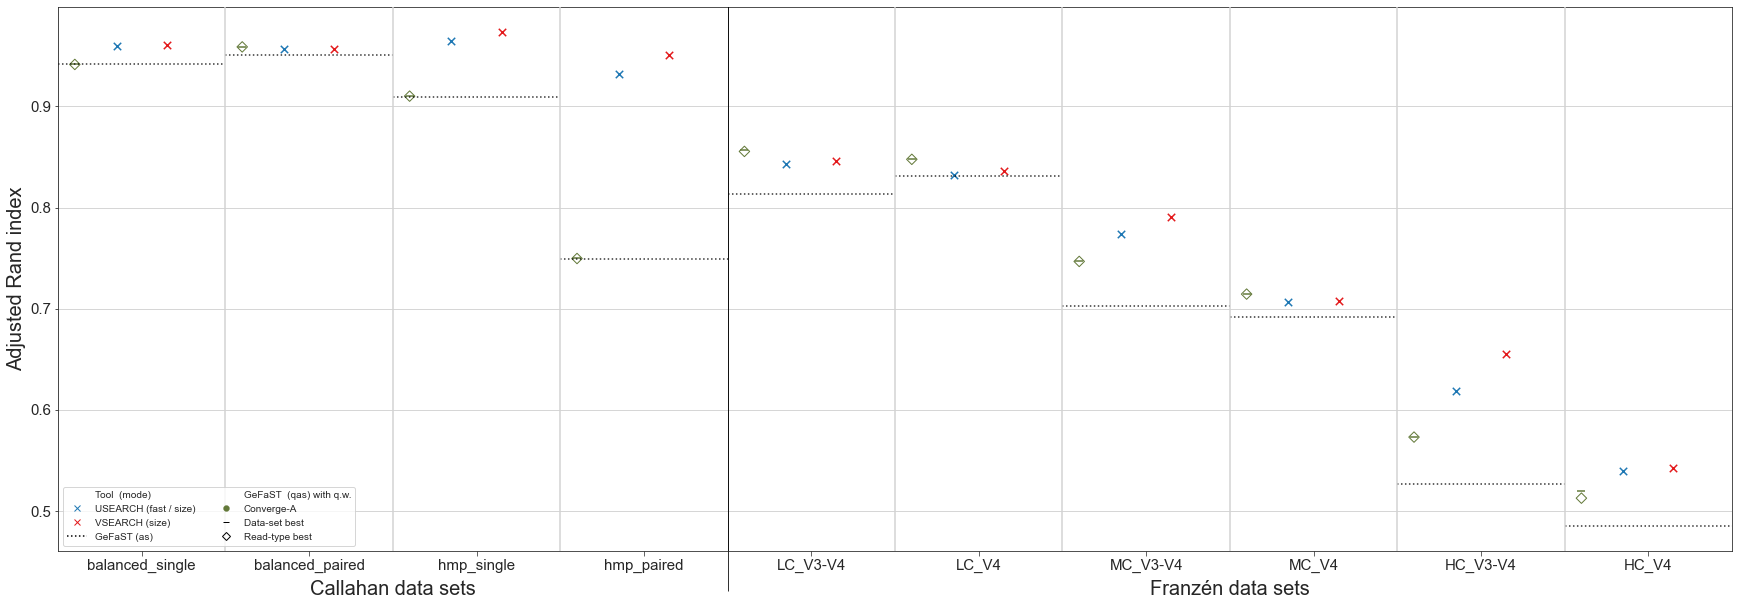

In [11]:
df = comparative_plot([('Callahan data sets', df_callahan_gefast_max_lvls, df_callahan_uvsearch_joined_max_avg,'callahan', ['balanced_single', 'balanced_paired', 'hmp_single', 'hmp_paired']), 
                       ('Franzén data sets', df_franzen_gefast_max_lvls, df_franzen_uvsearch_joined_max_avg, 'franzen', ['LC_V3-V4', 'LC_V4', 'MC_V3-V4', 'MC_V4', 'HC_V3-V4', 'HC_V4'])], 
                      'adjrandindex', (mode, qmode), select_metric = 'adjrandindex', qw_opts = [qw_option])
df.sort_values(by = ['qw_opt', 'data_set'])

Candidates for best choice based on maximum:

In [12]:
pd.Series([v.split(';')[0] for v in df['read_type_best']] + [v.split(';')[0] for v in df['data_set_best']]).value_counts()

v4 / mult / 15        5
v4 / mult / 1000      4
v4 / root / 4         4
v4 / root / 6         2
v4 / rootshift / 6    1
v4 / mult / 50        1
v4 / root / 5         1
v4 / mult / 10        1
v2 / root / 10        1
dtype: int64

-- *Average clustering quality*

,data_set,qw_opt,as_baseline,read_type_best,data_set_best
8,HC_V3-V4,ca,as; 0.290869,v4 / mult / 15; +0.100047,v4 / mult / 15; +0.100047
9,HC_V4,ca,as; 0.375390,v4 / mult / 5; -0.005269,v2 / linear / 20; -0.001395
4,LC_V3-V4,ca,as; 0.391904,v4 / mult / 15; +0.170470,v4 / mult / 15; +0.170470
5,LC_V4,ca,as; 0.738540,v4 / mult / 5; +0.008114,v4 / mult / 20; +0.012984
6,MC_V3-V4,ca,as; 0.360724,v4 / mult / 15; +0.140162,v4 / mult / 15; +0.140162
7,MC_V4,ca,as; 0.587243,v4 / mult / 5; +0.003295,v4 / mult / 10; +0.003717
1,balanced_paired,ca,as; 0.926949,v4 / linear / 5; +0.001217,v4 / linear / 0; +0.001237
0,balanced_single,ca,as; 0.913326,v1 / linear / 15; -0.000258,v4 / linear / 25; +0.000151
3,hmp_paired,ca,as; 0.692135,v4 / linear / 5; +0.005953,v4 / linear / 5; +0.005953
2,hmp_single,ca,as; 0.740704,v1 / linear / 15; +0.012166,v1 / linear / 15; +0.012166


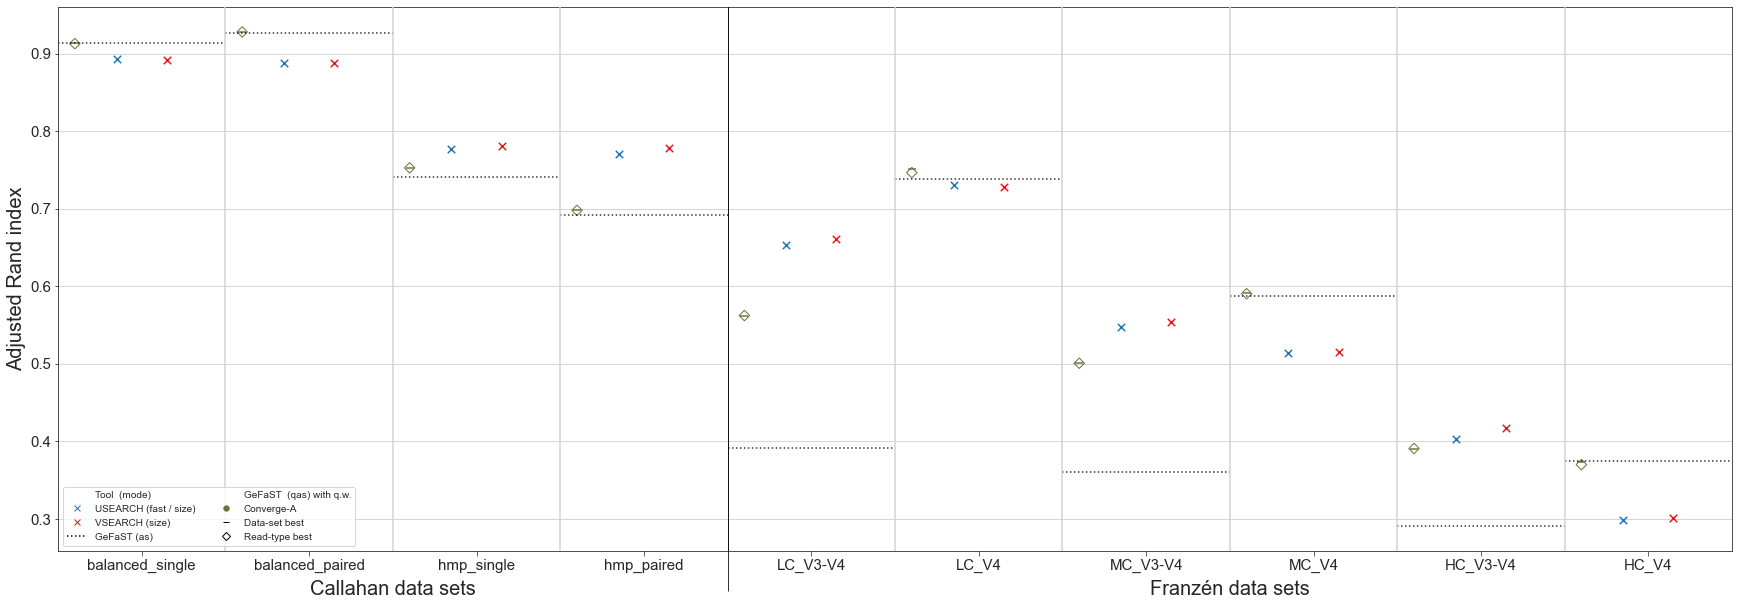

In [13]:
df = comparative_plot([('Callahan data sets', df_callahan_gefast_mean_lvls, df_callahan_uvsearch_joined_mean_avg,'callahan', ['balanced_single', 'balanced_paired', 'hmp_single', 'hmp_paired']), 
                      ('Franzén data sets', df_franzen_gefast_mean_lvls, df_franzen_uvsearch_joined_mean_avg, 'franzen', ['LC_V3-V4', 'LC_V4', 'MC_V3-V4', 'MC_V4', 'HC_V3-V4', 'HC_V4'])], 
                     'adjrandindex', (mode, qmode), select_metric = 'adjrandindex', qw_opts = [qw_option])
df.sort_values(by = ['qw_opt', 'data_set'])

Candidates for best choice based on average:

In [14]:
pd.Series([v.split(';')[0] for v in df['read_type_best']] + [v.split(';')[0] for v in df['data_set_best']]).value_counts()

v4 / mult / 15      6
v1 / linear / 15    3
v4 / mult / 5       3
v4 / linear / 5     3
v4 / mult / 20      1
v2 / linear / 20    1
v4 / mult / 10      1
v4 / linear / 25    1
v4 / linear / 0     1
dtype: int64

-- *N-best average clustering quality*

,data_set,qw_opt,as_baseline,read_type_best,data_set_best
8,HC_V3-V4,ca,as; 0.486434,v4 / mult / 10; +0.059485,v4 / mult / 10; +0.059485
9,HC_V4,ca,as; 0.450340,v4 / mult / 10; +0.000226,v1 / linear / 15; +0.003848
4,LC_V3-V4,ca,as; 0.690341,v4 / mult / 10; +0.142344,v4 / mult / 10; +0.142344
5,LC_V4,ca,as; 0.814839,v4 / mult / 10; +0.004295,v4 / rootshift / 3; +0.005708
6,MC_V3-V4,ca,as; 0.621592,v4 / mult / 10; +0.097548,v4 / mult / 10; +0.097548
7,MC_V4,ca,as; 0.660170,v4 / mult / 10; +0.011991,v4 / mult / 15; +0.014340
1,balanced_paired,ca,as; 0.947443,v2 / root / 4; +0.002959,v2 / root / 4; +0.002959
0,balanced_single,ca,as; 0.933077,muw / unboosted / none; 0.000000,v2 / root / 10; +0.002478
3,hmp_paired,ca,as; 0.729426,v2 / root / 4; +0.000017,v4 / linear / 0; +0.000060
2,hmp_single,ca,as; 0.831921,muw / unboosted / none; 0.000000,muw / unboosted / none; 0.000000


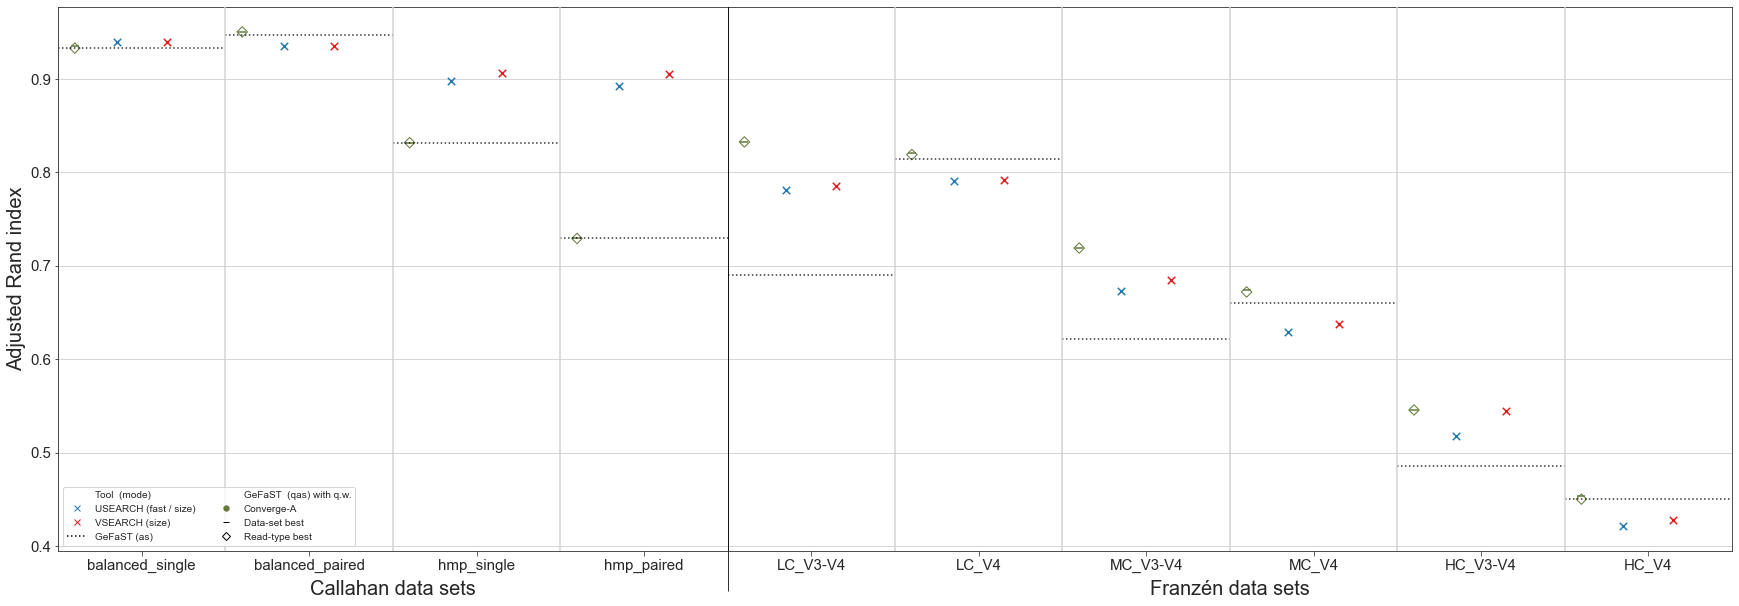

In [15]:
df = comparative_plot([('Callahan data sets', df_callahan_gefast_nbest_lvls, df_callahan_uvsearch_joined_nbest_avg,'callahan', ['balanced_single', 'balanced_paired', 'hmp_single', 'hmp_paired']), 
                      ('Franzén data sets', df_franzen_gefast_nbest_lvls, df_franzen_uvsearch_joined_nbest_avg, 'franzen', ['LC_V3-V4', 'LC_V4', 'MC_V3-V4', 'MC_V4', 'HC_V3-V4', 'HC_V4'])], 
                     'adjrandindex', (mode, qmode), select_metric = 'adjrandindex', qw_opts = [qw_option])
df.sort_values(by = ['qw_opt', 'data_set'])

Candidates for best choice based on N-best average:

In [16]:
pd.Series([v.split(';')[0] for v in df['read_type_best']] + [v.split(';')[0] for v in df['data_set_best']]).value_counts()

v4 / mult / 10            9
muw / unboosted / none    3
v2 / root / 4             3
v1 / linear / 15          1
v4 / mult / 15            1
v4 / linear / 0           1
v4 / rootshift / 3        1
v2 / root / 10            1
dtype: int64

Next, compare the performance of the candidates seen most often on the different data-set groups:

-- *Maximum clustering quality*

In [17]:
avg_diff_multiple([(df_franzen_gefast_joined_max_avg, [('V3-V4', ['LC_V3-V4', 'MC_V3-V4', 'HC_V3-V4']), ('V4', ['LC_V4', 'MC_V4', 'HC_V4'])], 'franzen'),
                   (df_callahan_gefast_joined_max_avg, [('paired', ['balanced_paired', 'hmp_paired']), ('single', ['balanced_single', 'hmp_single'])], 'callahan')], 
                  (mode, 'none', 'none', 'none', 'none'), 
                  [(qmode, 'v4', qw_option, 'mult', '10'),
                   (qmode, 'v4', qw_option, 'mult', '15'), 
                   (qmode, 'v4', qw_option, 'mult', '1000'),
                   (qmode, 'v4', qw_option, 'root', '4'),
                   (qmode, 'v4', qw_option, 'linear', '15'),
                   (qmode, 'v1', qw_option, 'linear', '5'),
                   (qmode, 'v2', qw_option, 'root', '4'),
                   (qmode, best_ub, qw_option, 'unboosted', 'none')])

,data_group,qas / v4 / ca / mult / 10,qas / v4 / ca / mult / 15,qas / v4 / ca / mult / 1000,qas / v4 / ca / root / 4,qas / v4 / ca / linear / 15,qas / v1 / ca / linear / 5,qas / v2 / ca / root / 4,qas / muw / ca / unboosted / none
0,V3-V4,0.044323,0.044368,0.008047,0.034594,0.003714,-0.680766,0.016774,0.004272
1,V4,0.018145,0.021430,-0.008243,0.022509,0.000057,-0.637987,-0.001487,0.000057
2,paired,0.000044,0.000052,-0.002819,0.004031,0.000000,-0.005413,0.003982,0.000000
3,single,0.000000,0.000000,0.000229,0.000000,0.000000,-0.047820,0.000000,0.000000


Based on maximum, `v4 / mult` with parameter 10 and 15, `v4 / root` with parameter 4 and `v2 / root` with parameter 4 performed best and better than the unboosted variant.   
The others were notably worse in their maximum clustering quality.

-- *Average clustering quality*

In [18]:
avg_diff_multiple([(df_franzen_gefast_joined_mean_avg, [('V3-V4', ['LC_V3-V4', 'MC_V3-V4', 'HC_V3-V4']), ('V4', ['LC_V4', 'MC_V4', 'HC_V4'])], 'franzen'),
                   (df_callahan_gefast_joined_mean_avg, [('paired', ['balanced_paired', 'hmp_paired']), ('single', ['balanced_single', 'hmp_single'])], 'callahan')], 
                  (mode, 'none', 'none', 'none', 'none'), 
                  [(qmode, 'v4', qw_option, 'mult', '10'),
                   (qmode, 'v4', qw_option, 'mult', '15'), 
                   (qmode, 'v4', qw_option, 'root', '4'),
                   (qmode, 'v2', qw_option, 'root', '4'),
                   (qmode, best_ub, qw_option, 'unboosted', 'none')])

,data_group,qas / v4 / ca / mult / 10,qas / v4 / ca / mult / 15,qas / v4 / ca / root / 4,qas / v2 / ca / root / 4,qas / muw / ca / unboosted / none
0,V3-V4,0.132348,0.136893,0.121929,0.060043,0.020728
1,V4,0.001790,0.000075,-0.006486,-0.009257,-0.000666
2,paired,-0.000012,-0.000017,-0.007444,-0.006139,0.000000
3,single,-0.004718,-0.007498,-0.018860,-0.013473,-0.000017


-- *N-best average clustering quality*

In [19]:
avg_diff_multiple([(df_franzen_gefast_joined_nbest_avg, [('V3-V4', ['LC_V3-V4', 'MC_V3-V4', 'HC_V3-V4']), ('V4', ['LC_V4', 'MC_V4', 'HC_V4'])], 'franzen'),
                   (df_callahan_gefast_joined_nbest_avg, [('paired', ['balanced_paired', 'hmp_paired']), ('single', ['balanced_single', 'hmp_single'])], 'callahan')], 
                  (mode, 'none', 'none', 'none', 'none'), 
                  [(qmode, 'v4', qw_option, 'mult', '10'),
                   (qmode, 'v4', qw_option, 'mult', '15'), 
                   (qmode, 'v4', qw_option, 'root', '4'),
                   (qmode, 'v2', qw_option, 'root', '4'),
                   (qmode, best_ub, qw_option, 'unboosted', 'none')])

,data_group,qas / v4 / ca / mult / 10,qas / v4 / ca / mult / 15,qas / v4 / ca / root / 4,qas / v2 / ca / root / 4,qas / muw / ca / unboosted / none
0,V3-V4,0.099792,0.097775,0.091378,0.057913,0.038110
1,V4,0.005504,0.005271,0.000283,-0.008421,-0.000082
2,paired,0.000018,0.000020,-0.000344,0.001488,0.000000
3,single,-0.002396,-0.002804,-0.003352,-0.001250,0.000000


`v4 / mult` with parameter 10 and 15 showed a higher robustness than the others.   
Both were usually more robust than `original_as` and unboosted (except for single).   
Parameter 10 was slightly better in terms of average and N-best, while 15 had a slightly larger maximum clustering quality.

In [20]:
best_v = 'v4'
best_b = 'mult'
best_bp = '15'

**Comparison of quality metrics of the picked boosted and unboosted variant with the quality-unweighted mode**

-- *Maximum clustering quality*

In [21]:
for m in ['adjrandindex', 'precision', 'recall']:
    print('%s:' % rename_map[m])
    display(avg_diff_multiple([(df_franzen_gefast_joined_max_avg, [('V3-V4', ['LC_V3-V4', 'MC_V3-V4', 'HC_V3-V4']), ('V4', ['LC_V4', 'MC_V4', 'HC_V4'])], 'franzen'),
                               (df_callahan_gefast_joined_max_avg, [('paired', ['balanced_paired', 'hmp_paired']), ('single', ['balanced_single', 'hmp_single'])], 'callahan')], 
                              (mode, 'none', 'none', 'none', 'none'), [(qmode, best_v, qw_option, best_b, best_bp), (qmode, best_ub, qw_option, 'unboosted', 'none')], metric = m))

Adjusted Rand index:


,data_group,qas / v4 / ca / mult / 15,qas / muw / ca / unboosted / none
0,V3-V4,0.044368,0.004272
1,V4,0.021430,0.000057
2,paired,0.000052,0.000000
3,single,0.000000,0.000000


Precision:


,data_group,qas / v4 / ca / mult / 15,qas / muw / ca / unboosted / none
0,V3-V4,0.028824,0.025405
1,V4,0.022331,-0.000061
2,paired,-0.000006,0.000000
3,single,0.000000,0.000000


Recall:


,data_group,qas / v4 / ca / mult / 15,qas / muw / ca / unboosted / none
0,V3-V4,0.006300,-0.033355
1,V4,-0.002497,0.000113
2,paired,0.000021,0.000000
3,single,0.000000,0.000000


Highest ARI improvements on Franzén data, accompanied by increased precision and relatively stable recall.   
Essentially no change on Callahan data.   
Boosted in general better than unboosted.

-- *Average clustering quality*

In [22]:
for m in ['adjrandindex', 'precision', 'recall']:
    print('%s:' % rename_map[m])
    display(avg_diff_multiple([(df_franzen_gefast_joined_mean_avg, [('V3-V4', ['LC_V3-V4', 'MC_V3-V4', 'HC_V3-V4']), ('V4', ['LC_V4', 'MC_V4', 'HC_V4'])], 'franzen'),
                               (df_callahan_gefast_joined_mean_avg, [('paired', ['balanced_paired', 'hmp_paired']), ('single', ['balanced_single', 'hmp_single'])], 'callahan')], 
                              (mode, 'none', 'none', 'none', 'none'), [(qmode, best_v, qw_option, best_b, best_bp), (qmode, best_ub, qw_option, 'unboosted', 'none')], metric = m))

Adjusted Rand index:


,data_group,qas / v4 / ca / mult / 15,qas / muw / ca / unboosted / none
0,V3-V4,0.136893,0.020728
1,V4,0.000075,-0.000666
2,paired,-0.000017,0.000000
3,single,-0.007498,-0.000017


Precision:


,data_group,qas / v4 / ca / mult / 15,qas / muw / ca / unboosted / none
0,V3-V4,-0.045918,-0.006161
1,V4,-0.017703,-0.000609
2,paired,-0.000112,0.000000
3,single,-0.002967,-0.000014


Recall:


,data_group,qas / v4 / ca / mult / 15,qas / muw / ca / unboosted / none
0,V3-V4,0.190136,0.028579
1,V4,0.021782,0.000056
2,paired,0.000013,0.000000
3,single,-0.001376,0.000004


On Franzén data (especially V3-V4), both ARI and recall of the (un)boosted variant were, averaged over the threshold range,   
better than for the quality-unweighted mode, which in turn was better in terms of precision and on Callahan data.   
Reversed precision-recall trade-off for average compared to maximum.   
In general, boosted again better than unboosted.

-- *N-best average clustering quality*

In [23]:
for m in ['adjrandindex', 'precision', 'recall']:
    print('%s:' % rename_map[m])
    display(avg_diff_multiple([(df_franzen_gefast_joined_nbest_avg, [('V3-V4', ['LC_V3-V4', 'MC_V3-V4', 'HC_V3-V4']), ('V4', ['LC_V4', 'MC_V4', 'HC_V4'])], 'franzen'),
                               (df_callahan_gefast_joined_nbest_avg, [('paired', ['balanced_paired', 'hmp_paired']), ('single', ['balanced_single', 'hmp_single'])], 'callahan')], 
                              (mode, 'none', 'none', 'none', 'none'), [(qmode, best_v, qw_option, best_b, best_bp), (qmode, best_ub, qw_option, 'unboosted', 'none')], metric = m))

Adjusted Rand index:


,data_group,qas / v4 / ca / mult / 15,qas / muw / ca / unboosted / none
0,V3-V4,0.097775,0.038110
1,V4,0.005271,-0.000082
2,paired,0.000020,0.000000
3,single,-0.002804,0.000000


Precision:


,data_group,qas / v4 / ca / mult / 15,qas / muw / ca / unboosted / none
0,V3-V4,-0.045615,-0.011887
1,V4,-0.006694,-0.000228
2,paired,-0.000017,0.000000
3,single,-0.002330,0.000000


Recall:


,data_group,qas / v4 / ca / mult / 15,qas / muw / ca / unboosted / none
0,V3-V4,0.157226,0.053637
1,V4,0.016676,0.000195
2,paired,0.000020,0.000000
3,single,0.000357,0.000000


Same tendencies as average.

**Absolute and relative difference of picked boosted and unboosted variant to quality-unweighted mode (ARI)**

Below tables state the following values for both the boosted and unboosted variant: the clustering quality of the alignment-score mode (`ref_val`), the clustering quality of the picked variant (`cmp_val`), the absolute difference between both (`abs_diff`), and the relative difference between both (`rel_diff`).   
For better readability, the two groups of columns separated by an additional column containing no values.

In [24]:
def show_detailed_diffs(portions, ref, cmps, metric = 'adjrandindex'):
    
    ref_mode, ref_v, ref_qw, ref_b, ref_bp = ref
    
    df_columns = ['data_group']
    for m, v, q, b, bp in cmps:
        df_columns.append('%s / %s / %s / %s / %s | ref_val' % (ref_mode, ref_v, ref_qw, ref_b, ref_bp))
        for s in ['cmp_val', 'abs_diff', 'rel_diff']: 
            df_columns.append('%s / %s / %s / %s / %s | %s' % (m, v, q, b, bp, s))
        df_columns.append('---')
    
    rows = []
    for df, data_set_groups, gt in portions:
        for (name, dsg) in data_set_groups:            
            ref_grp = df.loc[df['data_set'].isin(dsg) & (df['gt'] == gt) & (df['mode'] == ref_mode) & (df['v_opt'] == ref_v) & (df['qw_opt'] == ref_qw) & (df['b_opt'] == ref_b) & (df['b_param'] == ref_bp)]
            
            row = [name]
            for mode, v, qw, b, bp in cmps:
                cmp_grp = df.loc[df['data_set'].isin(dsg) & (df['gt'] == gt) & (df['mode'] == mode) & (df['v_opt'] == v) & (df['qw_opt'] == qw) & (df['b_opt'] == b) & (df['b_param'] == bp)]
                
                row.append(ref_grp[metric].mean())
                row.append(cmp_grp[metric].mean())
                row.append(cmp_grp[metric].mean() - ref_grp[metric].mean())
                row.append(cmp_grp[metric].mean() / ref_grp[metric].mean() - 1.0)
                row.append('---')
            
            rows.append(row)
            
    return pd.DataFrame(rows, columns = df_columns)

-- *Maximum clustering quality*

In [25]:
show_detailed_diffs([(df_franzen_gefast_joined_max_avg, [('LC_V3-V4', ['LC_V3-V4']), ('MC_V3-V4', ['MC_V3-V4']), ('HC_V3-V4', ['HC_V3-V4']), ('V3-V4', ['LC_V3-V4', 'MC_V3-V4', 'HC_V3-V4']), ('LC_V4', ['LC_V4']), ('MC_V4', ['MC_V4']), ('HC_V4', ['HC_V4']), ('V4', ['LC_V4', 'MC_V4', 'HC_V4']), ('Franzén', ['LC_V3-V4', 'LC_V4', 'MC_V3-V4', 'MC_V4', 'HC_V3-V4', 'HC_V4'])], 'franzen'),
                     (df_callahan_gefast_joined_max_avg, [('balanced_paired', ['balanced_paired']), ('hmp_paired', ['hmp_paired']), ('paired', ['balanced_paired', 'hmp_paired']), ('balanced_single', ['balanced_single']), ('hmp_single', ['hmp_single']), ('single', ['balanced_single', 'hmp_single']), ('Callahan', ['balanced_paired', 'balanced_single', 'hmp_paired', 'hmp_single'])], 'callahan')], 
                    (mode, 'none', 'none', 'none', 'none'), [(qmode, best_v, qw_option, best_b, best_bp), (qmode, best_ub, qw_option, 'unboosted', 'none')], metric = 'adjrandindex')

,data_group,as / none / none / none / none | ref_val,qas / v4 / ca / mult / 15 | cmp_val,qas / v4 / ca / mult / 15 | abs_diff,qas / v4 / ca / mult / 15 | rel_diff,---,as / none / none / none / none | ref_val,qas / muw / ca / unboosted / none | cmp_val,qas / muw / ca / unboosted / none | abs_diff,qas / muw / ca / unboosted / none | rel_diff,---
0,LC_V3-V4,0.813486,0.855491,0.042005,0.051635,---,0.813486,0.814670,0.001183,0.001455,---
1,MC_V3-V4,0.702338,0.746762,0.044423,0.063251,---,0.702338,0.708068,0.005729,0.008158,---
2,HC_V3-V4,0.526475,0.573151,0.046677,0.088659,---,0.526475,0.532377,0.005902,0.011210,---
3,V3-V4,0.680766,0.725134,0.044368,0.065174,---,0.680766,0.685038,0.004272,0.006275,---
4,LC_V4,0.830749,0.845573,0.014824,0.017844,---,0.830749,0.830954,0.000205,0.000247,---
5,MC_V4,0.691493,0.712338,0.020845,0.030145,---,0.691493,0.691568,0.000075,0.000109,---
6,HC_V4,0.485187,0.513807,0.028620,0.058989,---,0.485187,0.485077,-0.000109,-0.000226,---
7,V4,0.669143,0.690573,0.021430,0.032026,---,0.669143,0.669200,0.000057,0.000085,---
8,Franzén,0.674955,0.707854,0.032899,0.048743,---,0.674955,0.677119,0.002164,0.003207,---
9,balanced_paired,0.950865,0.950865,0.000001,0.000001,---,0.950865,0.950865,0.000000,0.000000,---


-- *Average clustering quality*

In [26]:
show_detailed_diffs([(df_franzen_gefast_joined_mean_avg, [('LC_V3-V4', ['LC_V3-V4']), ('MC_V3-V4', ['MC_V3-V4']), ('HC_V3-V4', ['HC_V3-V4']), ('V3-V4', ['LC_V3-V4', 'MC_V3-V4', 'HC_V3-V4']), ('LC_V4', ['LC_V4']), ('MC_V4', ['MC_V4']), ('HC_V4', ['HC_V4']), ('V4', ['LC_V4', 'MC_V4', 'HC_V4']), ('Franzén', ['LC_V3-V4', 'LC_V4', 'MC_V3-V4', 'MC_V4', 'HC_V3-V4', 'HC_V4'])], 'franzen'),
                     (df_callahan_gefast_joined_mean_avg, [('balanced_paired', ['balanced_paired']), ('hmp_paired', ['hmp_paired']), ('paired', ['balanced_paired', 'hmp_paired']), ('balanced_single', ['balanced_single']), ('hmp_single', ['hmp_single']), ('single', ['balanced_single', 'hmp_single']), ('Callahan', ['balanced_paired', 'balanced_single', 'hmp_paired', 'hmp_single'])], 'callahan')], 
                    (mode, 'none', 'none', 'none', 'none'), [(qmode, best_v, qw_option, best_b, best_bp), (qmode, best_ub, qw_option, 'unboosted', 'none')], metric = 'adjrandindex')

,data_group,as / none / none / none / none | ref_val,qas / v4 / ca / mult / 15 | cmp_val,qas / v4 / ca / mult / 15 | abs_diff,qas / v4 / ca / mult / 15 | rel_diff,---,as / none / none / none / none | ref_val,qas / muw / ca / unboosted / none | cmp_val,qas / muw / ca / unboosted / none | abs_diff,qas / muw / ca / unboosted / none | rel_diff,---
0,LC_V3-V4,0.391904,0.562374,0.170470,0.434980,---,0.391904,0.419485,0.027582,0.070379,---
1,MC_V3-V4,0.360724,0.500887,0.140162,0.388558,---,0.360724,0.381952,0.021227,0.058846,---
2,HC_V3-V4,0.290869,0.390917,0.100047,0.343960,---,0.290869,0.304243,0.013374,0.045979,---
3,V3-V4,0.347832,0.484726,0.136893,0.393561,---,0.347832,0.368560,0.020728,0.059591,---
4,LC_V4,0.738540,0.751091,0.012551,0.016995,---,0.738540,0.738506,-0.000034,-0.000045,---
5,MC_V4,0.587243,0.589780,0.002537,0.004321,---,0.587243,0.586675,-0.000568,-0.000967,---
6,HC_V4,0.375390,0.360527,-0.014863,-0.039593,---,0.375390,0.373993,-0.001397,-0.003721,---
7,V4,0.567058,0.567133,0.000075,0.000133,---,0.567058,0.566391,-0.000666,-0.001175,---
8,Franzén,0.457445,0.525929,0.068484,0.149711,---,0.457445,0.467476,0.010031,0.021928,---
9,balanced_paired,0.926949,0.926958,0.000008,0.000009,---,0.926949,0.926949,0.000000,0.000000,---


-- *N-best average clustering quality*

In [27]:
show_detailed_diffs([(df_franzen_gefast_joined_nbest_avg, [('LC_V3-V4', ['LC_V3-V4']), ('MC_V3-V4', ['MC_V3-V4']), ('HC_V3-V4', ['HC_V3-V4']), ('V3-V4', ['LC_V3-V4', 'MC_V3-V4', 'HC_V3-V4']), ('LC_V4', ['LC_V4']), ('MC_V4', ['MC_V4']), ('HC_V4', ['HC_V4']), ('V4', ['LC_V4', 'MC_V4', 'HC_V4']), ('Franzén', ['LC_V3-V4', 'LC_V4', 'MC_V3-V4', 'MC_V4', 'HC_V3-V4', 'HC_V4'])], 'franzen'),
                     (df_callahan_gefast_joined_nbest_avg, [('balanced_paired', ['balanced_paired']), ('hmp_paired', ['hmp_paired']), ('paired', ['balanced_paired', 'hmp_paired']), ('balanced_single', ['balanced_single']), ('hmp_single', ['hmp_single']), ('single', ['balanced_single', 'hmp_single']), ('Callahan', ['balanced_paired', 'balanced_single', 'hmp_paired', 'hmp_single'])], 'callahan')], 
                    (mode, 'none', 'none', 'none', 'none'), [(qmode, best_v, qw_option, best_b, best_bp), (qmode, best_ub, qw_option, 'unboosted', 'none')], metric = 'adjrandindex')

,data_group,as / none / none / none / none | ref_val,qas / v4 / ca / mult / 15 | cmp_val,qas / v4 / ca / mult / 15 | abs_diff,qas / v4 / ca / mult / 15 | rel_diff,---,as / none / none / none / none | ref_val,qas / muw / ca / unboosted / none | cmp_val,qas / muw / ca / unboosted / none | abs_diff,qas / muw / ca / unboosted / none | rel_diff,---
0,LC_V3-V4,0.690341,0.830945,0.140604,0.203673,---,0.690341,0.741892,0.051551,0.074674,---
1,MC_V3-V4,0.621592,0.717106,0.095514,0.153660,---,0.621592,0.660585,0.038993,0.062731,---
2,HC_V3-V4,0.486434,0.543643,0.057209,0.117609,---,0.486434,0.510222,0.023788,0.048902,---
3,V3-V4,0.599456,0.697231,0.097775,0.163107,---,0.599456,0.637566,0.038110,0.063575,---
4,LC_V4,0.814839,0.819557,0.004718,0.005790,---,0.814839,0.814772,-0.000067,-0.000082,---
5,MC_V4,0.660170,0.674510,0.014340,0.021721,---,0.660170,0.660210,0.000040,0.000061,---
6,HC_V4,0.450340,0.447095,-0.003244,-0.007204,---,0.450340,0.450120,-0.000220,-0.000488,---
7,V4,0.641783,0.647054,0.005271,0.008214,---,0.641783,0.641701,-0.000082,-0.000128,---
8,Franzén,0.620619,0.672143,0.051523,0.083019,---,0.620619,0.639633,0.019014,0.030637,---
9,balanced_paired,0.947443,0.947447,0.000004,0.000005,---,0.947443,0.947443,0.000000,0.000000,---


**Overview of the clustering quality of the picked variant compared to the other variants**

In the following, plots each vertical line corresponds to a group of variants using the same boosting function, boosting type (inner or outer), depicting the range of values of the quality metrics covered by varying the boosting parameter.   
The cross marks the clustering quality of the picked variant.

In [28]:
def overview_plot(portions, modes, metric, 
                  qw_opt, pick,
                  v_opt_groups = [('Unweighted matches', 'muw', ['v2', 'v4']), ('Weighted matches', 'mw', ['v1', 'v3'])], 
                  leg_positions = [(1, 0, 'best')], fs = (40, 20), plot_file = None):
    mode, qmode = modes
    pick_v, pick_b, pick_bp = pick

    colour_palette = sb.color_palette('Paired')
    colours = dict((v, colour_palette[i]) for i, v in  enumerate('%s_%s' % (bf, io) for bf in ['linear', 'mult', 'root', 'rootshift'] for io in ['inner', 'outer']))
    colours['ref'] = 'black'
    colours['pick'] = colour_palette[9]
    markers = {'pick': 'x', 'border': '_'}
    marker_size = 80
    vwidth = 5

    label_map = {'precision': 'Precision', 'recall': 'Recall', 'adjrandindex': 'Adjusted Rand index', 
                 'c': 'Clement', 'ca': 'Converge-A', 'cb': 'Converge-B', 'f': 'Frith',
                 'ka': 'Kim-A', 'kb': 'Kim-B', 'ma': 'Malde-A', 'mb': 'Malde-B', 'mc': 'Malde-C'}
    xticklabel_size = 25
    yticklabel_size = 25
    xlabel_size = 30
    ylabel_size = 30
    title_size = 35
    leg_size = 16
    
    width = 0.7
    start_val = -0.325
    b_step = 0.2
    v_step = 0.05

    sb.set_style('white')
    fig, axes = plt.subplots(nrows = len(portions), ncols = len(v_opt_groups), figsize = fs, sharey = 'row')


    for i, (name, dfg, data) in enumerate(portions):      
        for j, (opt_name, ub_opt, v_opts) in enumerate(v_opt_groups):

            if len(portions) > 1 and len(v_opt_groups) > 1:
                ax = axes[i][j]
            elif len(portions) > 1:
                ax = axes[i]
            elif len(v_opt_groups) > 1:
                ax = axes[j]
            else:
                ax = axes

            data_sets = sorted(dfg['data_set'].unique()) if data == 'sorted' else data

            legend_markers = []
            legend_labels = []

            leg_cols = 2
            
            # Boosting functions and position (colours)
            legend_markers.append(plt.Line2D([0,0],[0,0], marker = '', mew = 0.3, linestyle = ''))
            legend_labels.append('Boosting function (type)')
            for bf in ['linear', 'mult', 'root', 'rootshift']:
                for io in ['inner', 'outer']:
                    legend_markers.append(plt.Line2D([0,0],[0,0], markeredgecolor = colours['%s_%s' % (bf, io)], marker = 'o', markerfacecolor = colours['%s_%s' % (bf, io)], mew = 0.3, linestyle = ''))
                    legend_labels.append('%s (%s)' % (bf, io))

            # Reference values
            legend_markers.append(plt.Line2D([0,0],[0,0], marker = '', mew = 0.3, linestyle = ''))
            legend_labels.append('Reference values')
            legend_markers.append(plt.Line2D([0,0],[1,0], marker = '', color = 'black', mew = 0.3, linestyle = '--'))
            legend_labels.append('quality-unweighted mode (%s)' % mode)
            legend_markers.append(plt.Line2D([0,0],[1,0], marker = '', color = 'black', mew = 0.3, linestyle = ':'))
            legend_labels.append('unboosted')
            legend_markers.append(plt.Line2D([0,0],[0,0], marker = markers['pick'], markeredgecolor = colours['pick'], markerfacecolor = colours['pick'], linestyle = ''))
            legend_labels.append('%s / %s / %s' % (pick_v, pick_b, pick_bp))
            
            for _ in range(0, 9 - 4):
                legend_markers.append(plt.Line2D([0,0],[0,0], marker = '', mew = 0.3, linestyle = ''))
                legend_labels.append('')


            for d, ds in enumerate(data_sets):
                
                    
                ax.hlines(y = dfg.loc[(dfg['mode'] == mode) & (dfg['data_set'] == ds), metric].iloc[0], xmin = d - 0.5, xmax = d + 0.5, color = colours['ref'], linestyle = '--', alpha = 0.6)
                
                df_ub = dfg.loc[(dfg['mode'] == qmode) & (dfg['data_set'] == ds) & (dfg['v_opt'] == ub_opt) & (dfg['qw_opt'] == qw_opt)]
                ax.hlines(y = df_ub[metric].iloc[0], xmin = d - 0.5, xmax = d + 0.5, colors = colours['ref'], linestyle = ':', alpha = 0.8)   
                
                df_pick = dfg.loc[(dfg['mode'] == qmode) & (dfg['data_set'] == ds) & (dfg['v_opt'] == pick_v) & (dfg['qw_opt'] == qw_opt) & (dfg['b_opt'] == pick_b) & (dfg['b_param'] == pick_bp)]
                ax.scatter(d, df_pick[metric].iloc[0], color = colours['pick'], marker = markers['pick'], s = marker_size)
                
                for k, v_opt in enumerate(v_opts):
                    io_val = 'inner' if v_opt in ['v1', 'v2'] else 'outer'
                    
                    x_values = []
                    min_values = []
                    max_values = []
                    colour_values = []

                    df_qw = dfg.loc[(dfg['mode'] == qmode) & (dfg['data_set'] == ds) & (dfg['v_opt'] == v_opt) & (dfg['qw_opt'] == qw_opt)]

                    for l, (b_opt, grp) in enumerate(df_qw.groupby(by = 'b_opt')):
                        x_val = d + start_val + b_step * l + v_step * k #+ 0.03*d
                        x_values.append(x_val)
                        min_values.append(grp[metric].min())
                        max_values.append(grp[metric].max())
                        colour_values.append(colours['%s_%s' % (b_opt, io_val)])
                    ax.vlines(x = x_values, ymin = min_values, ymax = max_values, colors = colour_values, linewidth = vwidth)
                    ax.scatter(x_values, min_values, color = colour_values, marker = markers['border'], s = marker_size)
                    ax.scatter(x_values, max_values, color = colour_values, marker = markers['border'], s = marker_size)



            xlabel = 'Data set'
            xticks = range(0, len(data_sets))
            xtick_labels = data_sets

            ax.set_xticks(xticks, minor = True)
            ax.set_xticks([x + 0.5 for x in xticks[:-1]], minor = False)

            ax.set_xticklabels(xtick_labels, fontsize = xticklabel_size, minor = True)
            ax.set_xticklabels('', minor = False)

            ax.tick_params(axis = 'x', which = 'minor', direction = 'out', length = 5, color = 'black')        
            ax.tick_params(which = 'major', left = (j == 0))
            ax.tick_params(which = 'minor', bottom = True)
            ax.tick_params(axis = 'y', labelsize = yticklabel_size)

            ax.set_xlim((xticks[0] - 0.5, xticks[-1] + 0.5))

            ax.grid(True)

            if i == (len(portions) - 1):
                ax.set_xlabel(xlabel, fontsize = xlabel_size)
            if j == 0:
                ax.set_ylabel('%s\n\n%s' % (name, label_map[metric]), fontsize = ylabel_size)

            if i == 0:
                ax.set_title(opt_name, fontsize = title_size)


            for leg_row, leg_col, leg_loc in leg_positions:
                if leg_row == i and leg_col == j:
                    ax.legend(legend_markers, legend_labels, fontsize = leg_size, markerscale = 1.5, ncol = leg_cols, loc = leg_loc)

            
        
    plt.subplots_adjust(wspace = 0.1)

    if plot_file is not None:
        plt.savefig(plot_file, format = 'pdf', dpi = 1200, bbox_inches = 'tight')

-- *Maximum clustering quality*

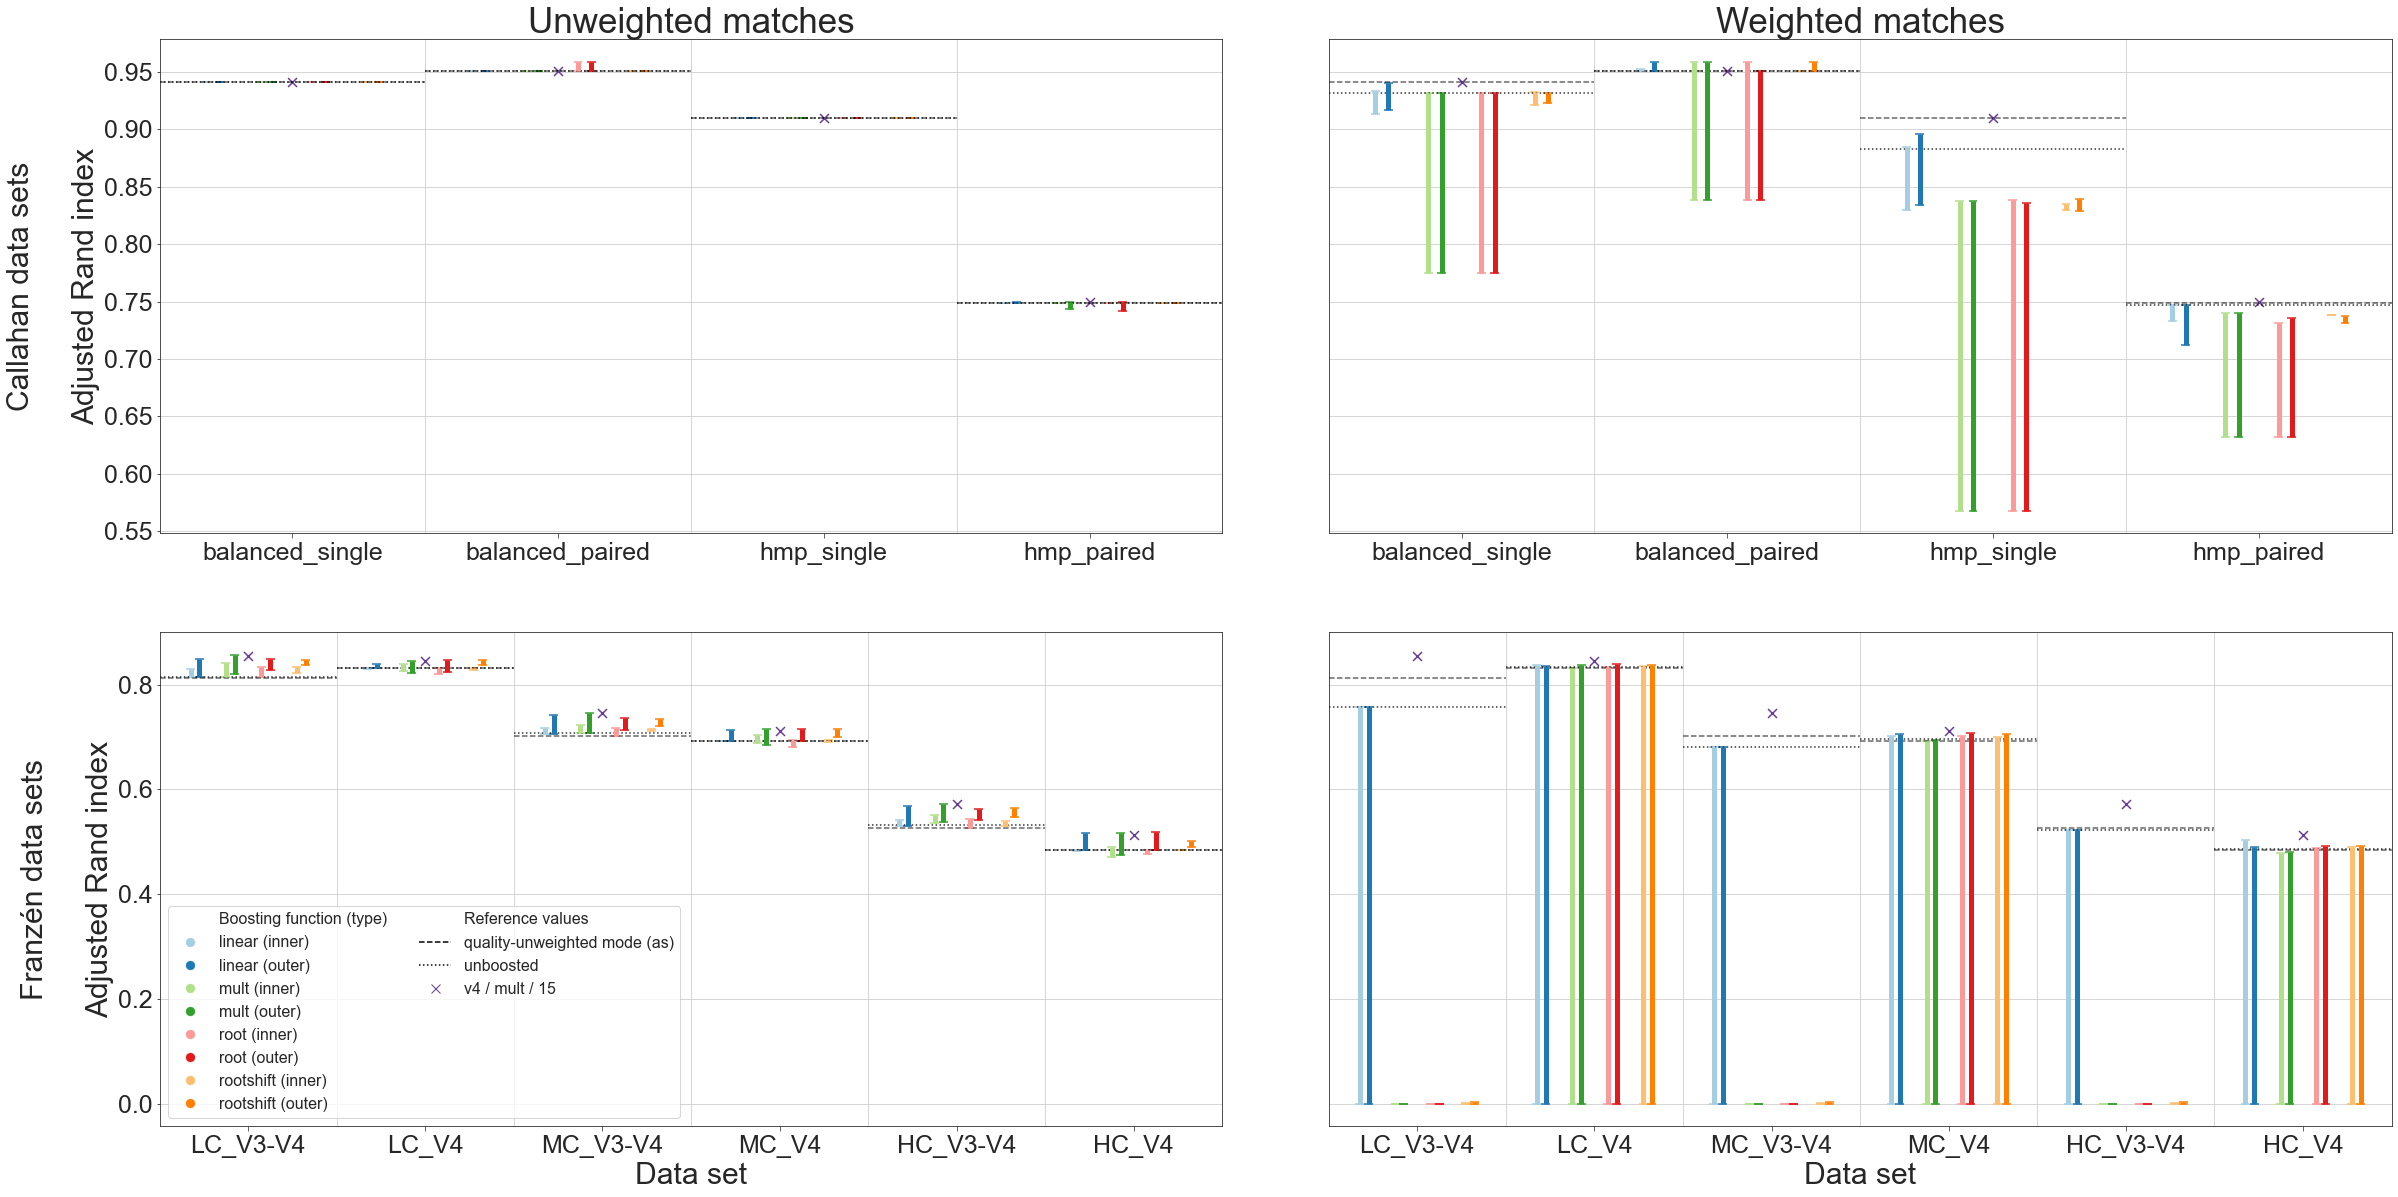

In [29]:
portions = [('Callahan data sets', df_callahan_gefast_joined_max_avg, ['balanced_single', 'balanced_paired', 'hmp_single', 'hmp_paired']), 
            ('Franzén data sets', df_franzen_gefast_joined_max_avg, ['LC_V3-V4', 'LC_V4', 'MC_V3-V4', 'MC_V4', 'HC_V3-V4', 'HC_V4'])]
modes = (mode, qmode)
metric = 'adjrandindex'
overview_plot(portions, modes, metric, qw_option, (best_v, best_b, best_bp))

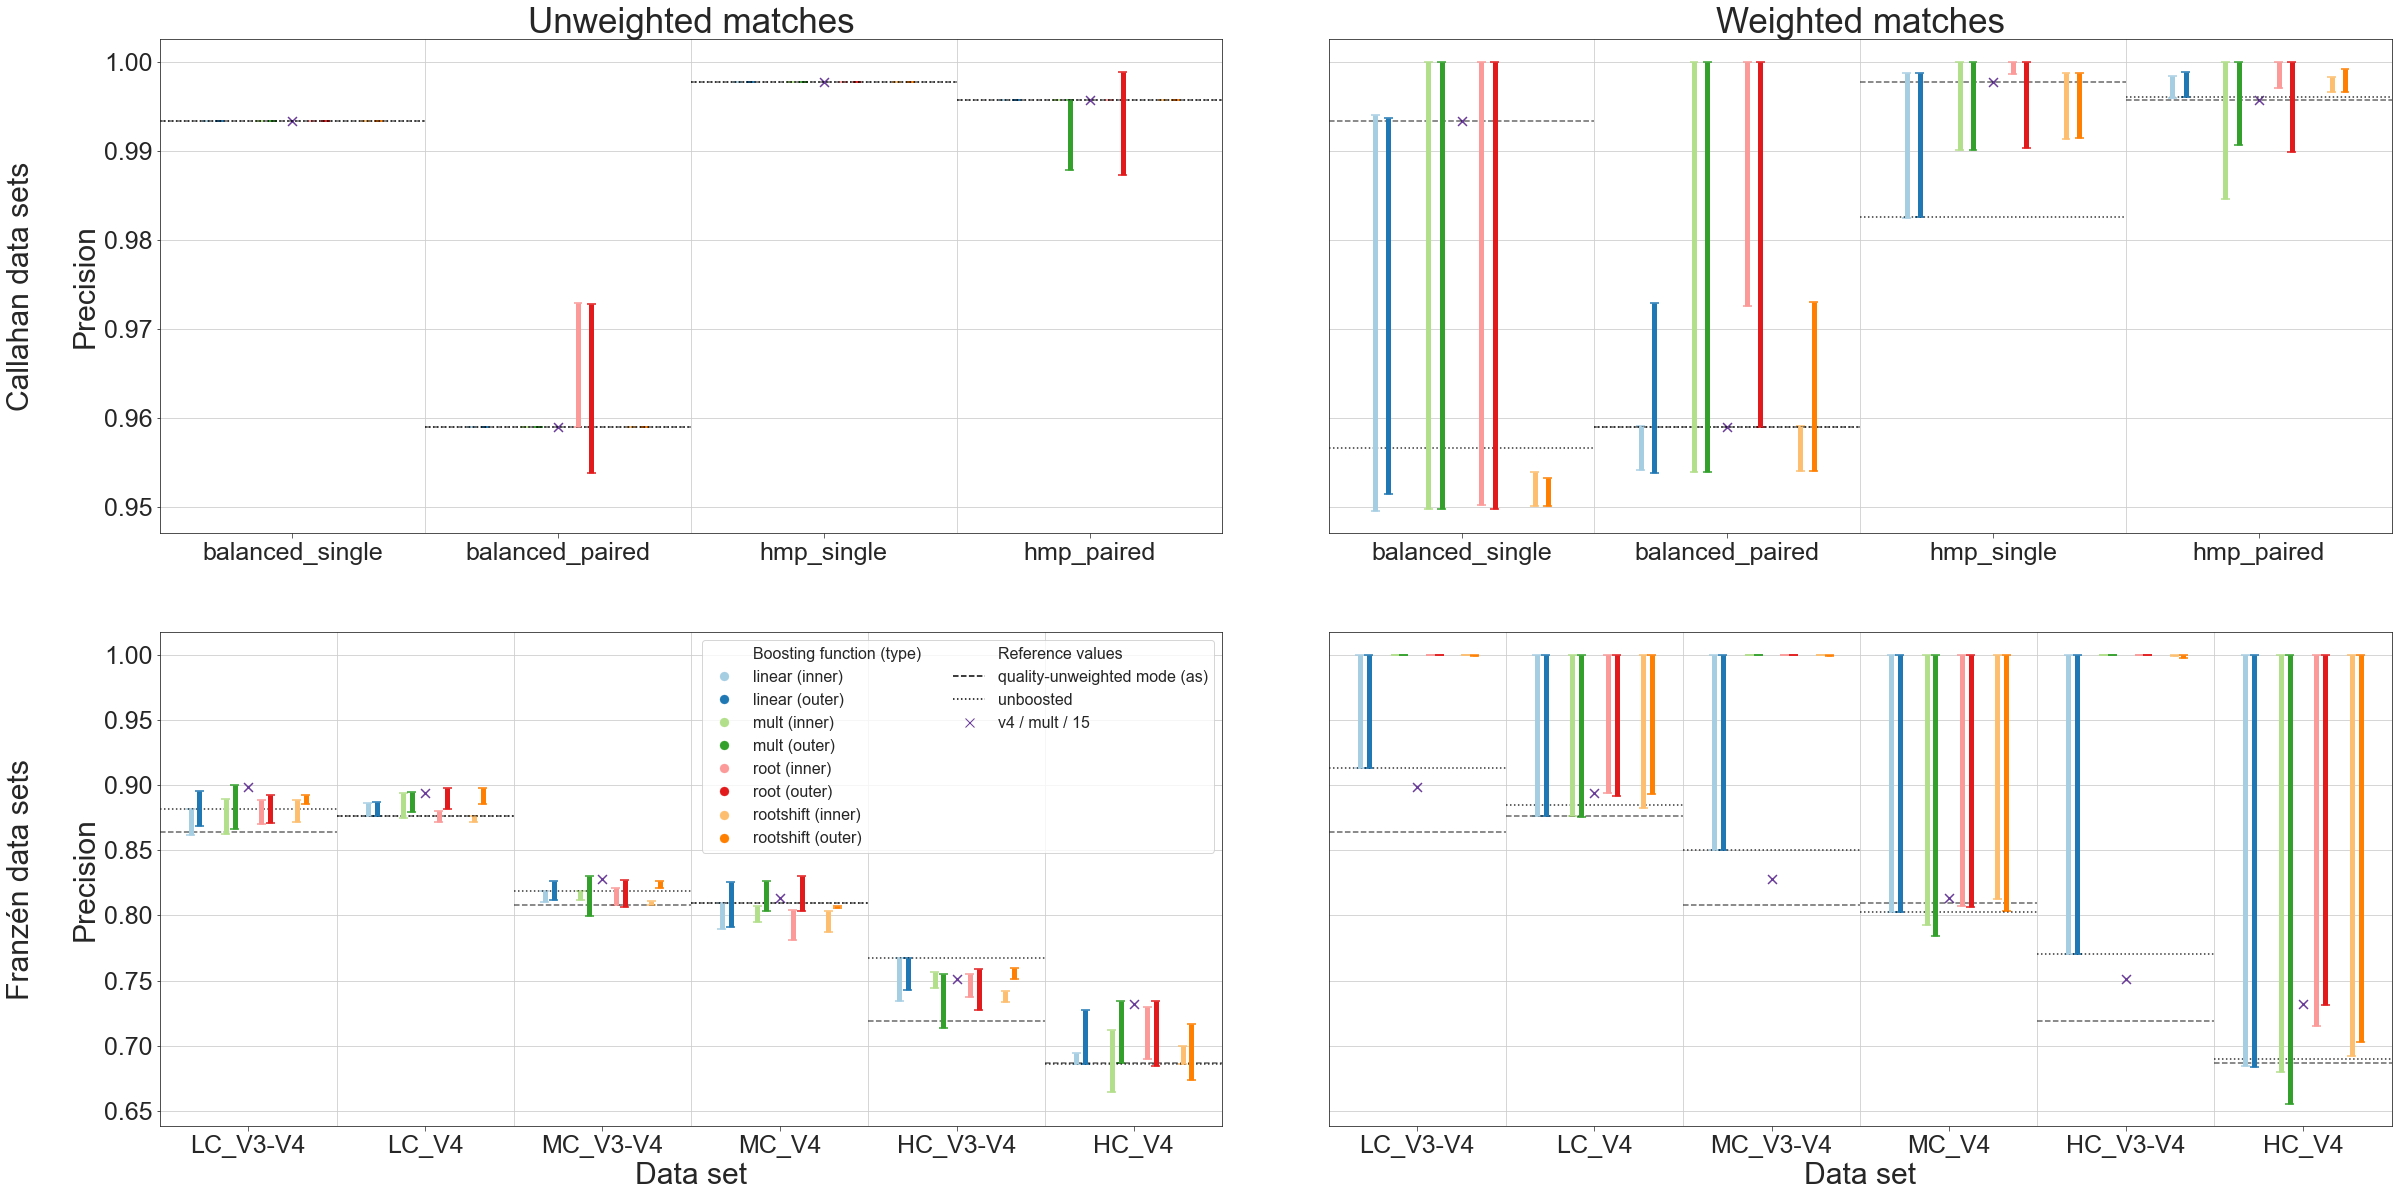

In [30]:
portions = [('Callahan data sets', df_callahan_gefast_joined_max_avg, ['balanced_single', 'balanced_paired', 'hmp_single', 'hmp_paired']), 
            ('Franzén data sets', df_franzen_gefast_joined_max_avg, ['LC_V3-V4', 'LC_V4', 'MC_V3-V4', 'MC_V4', 'HC_V3-V4', 'HC_V4'])]
modes = (mode, qmode)
metric = 'precision'
overview_plot(portions, modes, metric, qw_option, (best_v, best_b, best_bp))

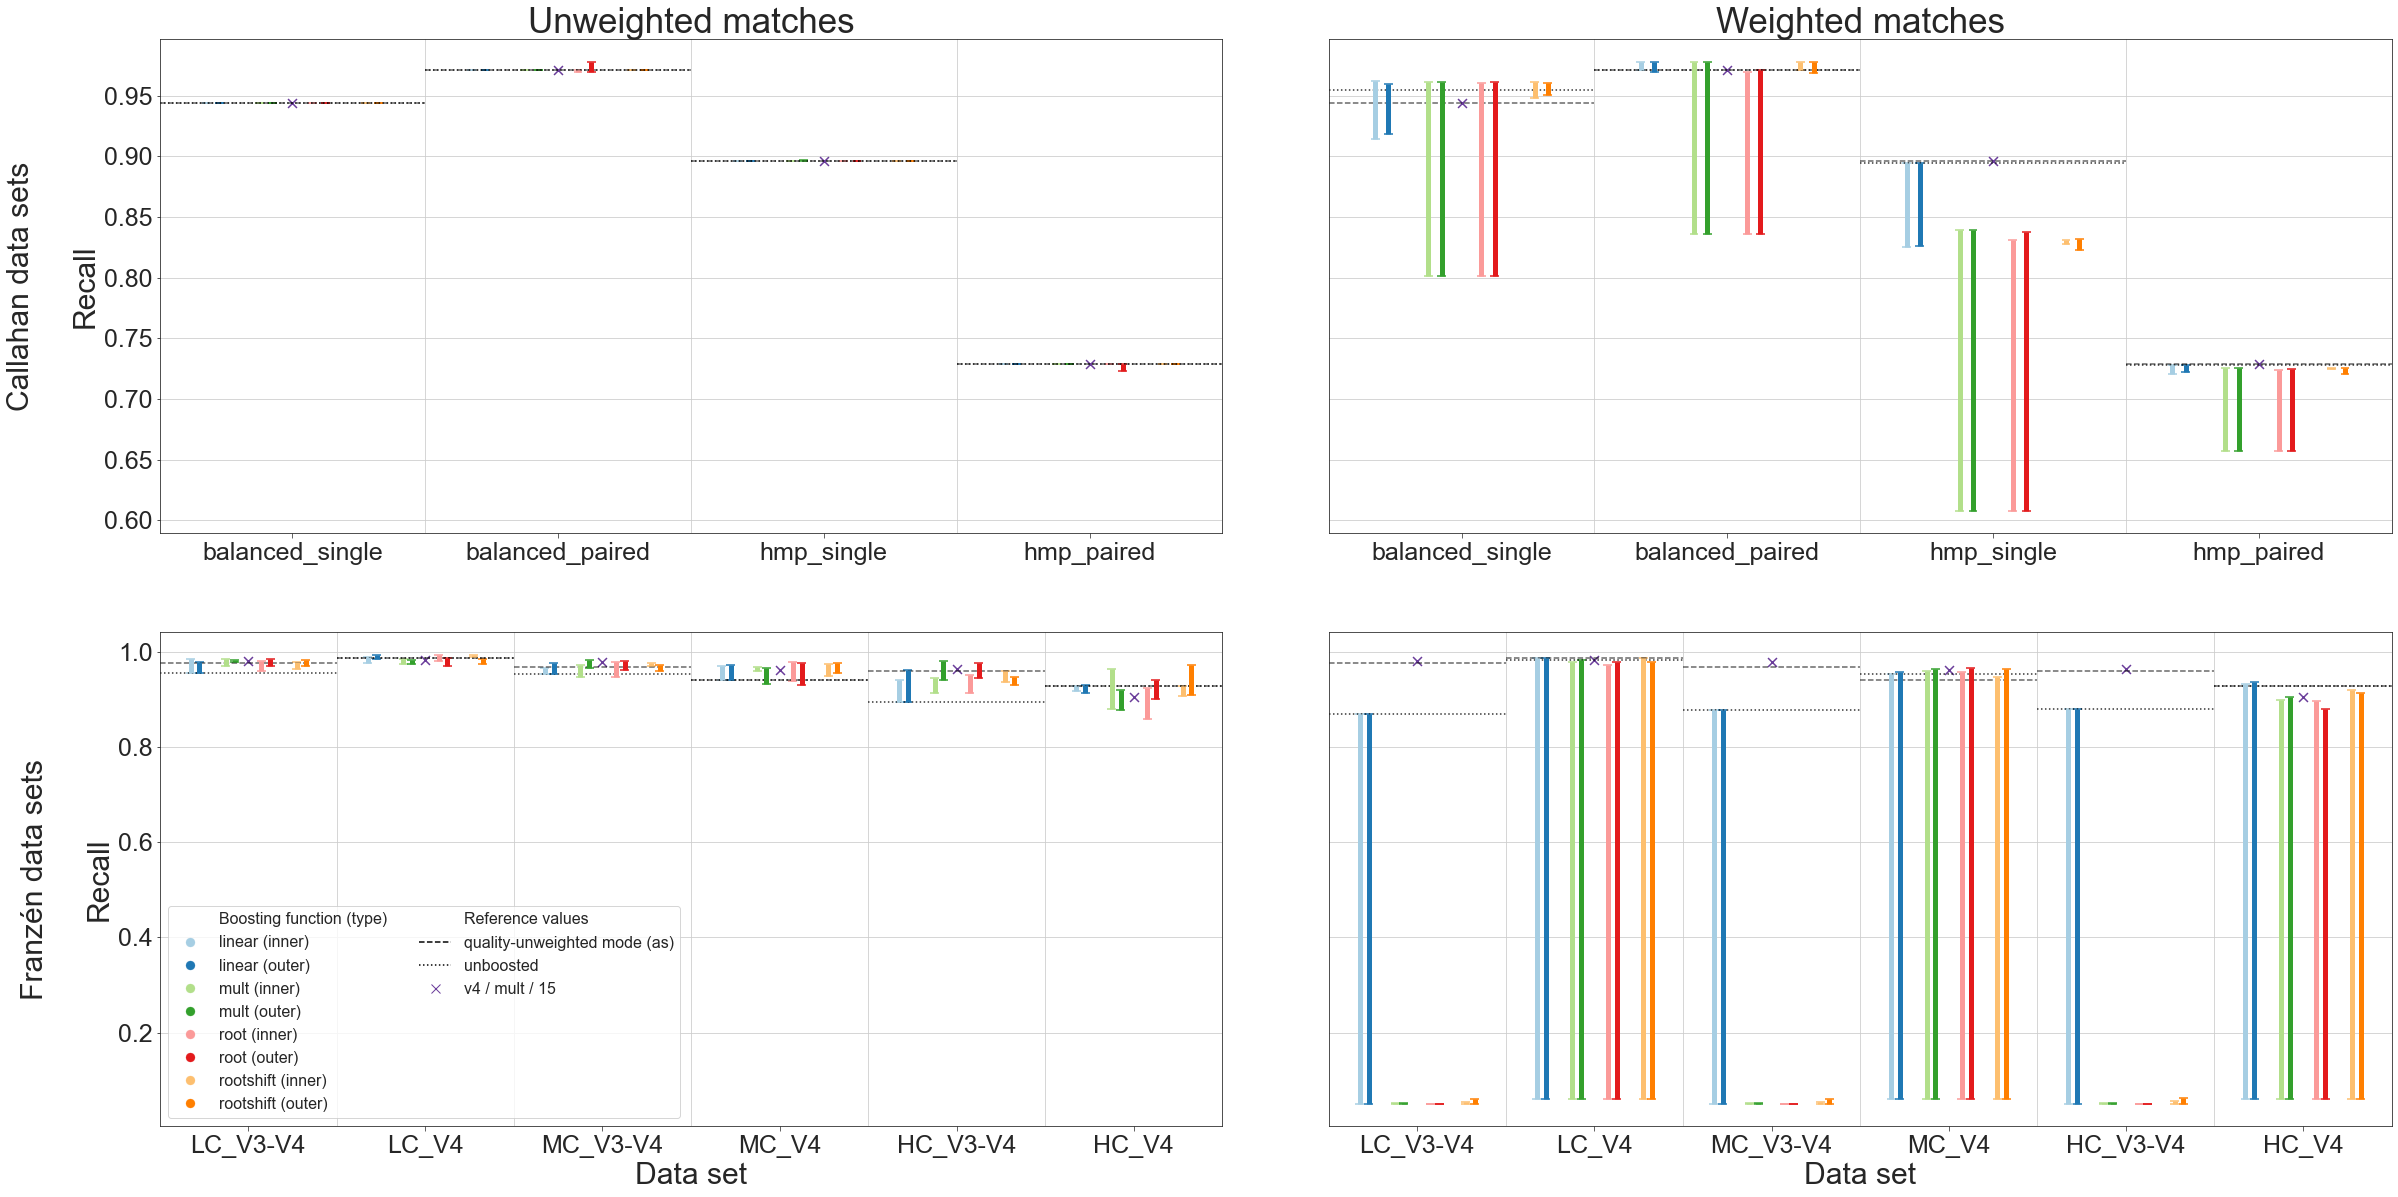

In [31]:
portions = [('Callahan data sets', df_callahan_gefast_joined_max_avg, ['balanced_single', 'balanced_paired', 'hmp_single', 'hmp_paired']), 
            ('Franzén data sets', df_franzen_gefast_joined_max_avg, ['LC_V3-V4', 'LC_V4', 'MC_V3-V4', 'MC_V4', 'HC_V3-V4', 'HC_V4'])]
modes = (mode, qmode)
metric = 'recall'
overview_plot(portions, modes, metric, qw_option, (best_v, best_b, best_bp))

Weighted matches did not really work with Converge-A (almost regardless of data, except balanced_paired).   
High precision possible but often much lower recall, leading at best to small isolated improvements.   

With unweighted matches, ARI improvements on all Franzén data sets and – to differing extent – for all boosting functions.   
Outer boosting worked better with Converge-A.   
No consistent improvement on Callahan data, where ARI was basically the same as for `original_as`.   
All boosting functions can achieve notable improvements in terms of precision on the Franzén data sets (especially V3-V4 data sets), but usually no difference on Callahan data sets.   
The recall is less affected and also already very high for the quality-unweighted mode on Franzén data.   
We, thus, observed a mix of small increases and decreases. On Callahan, the recall again was essentially like `original_as`.

-- *Average clustering quality*

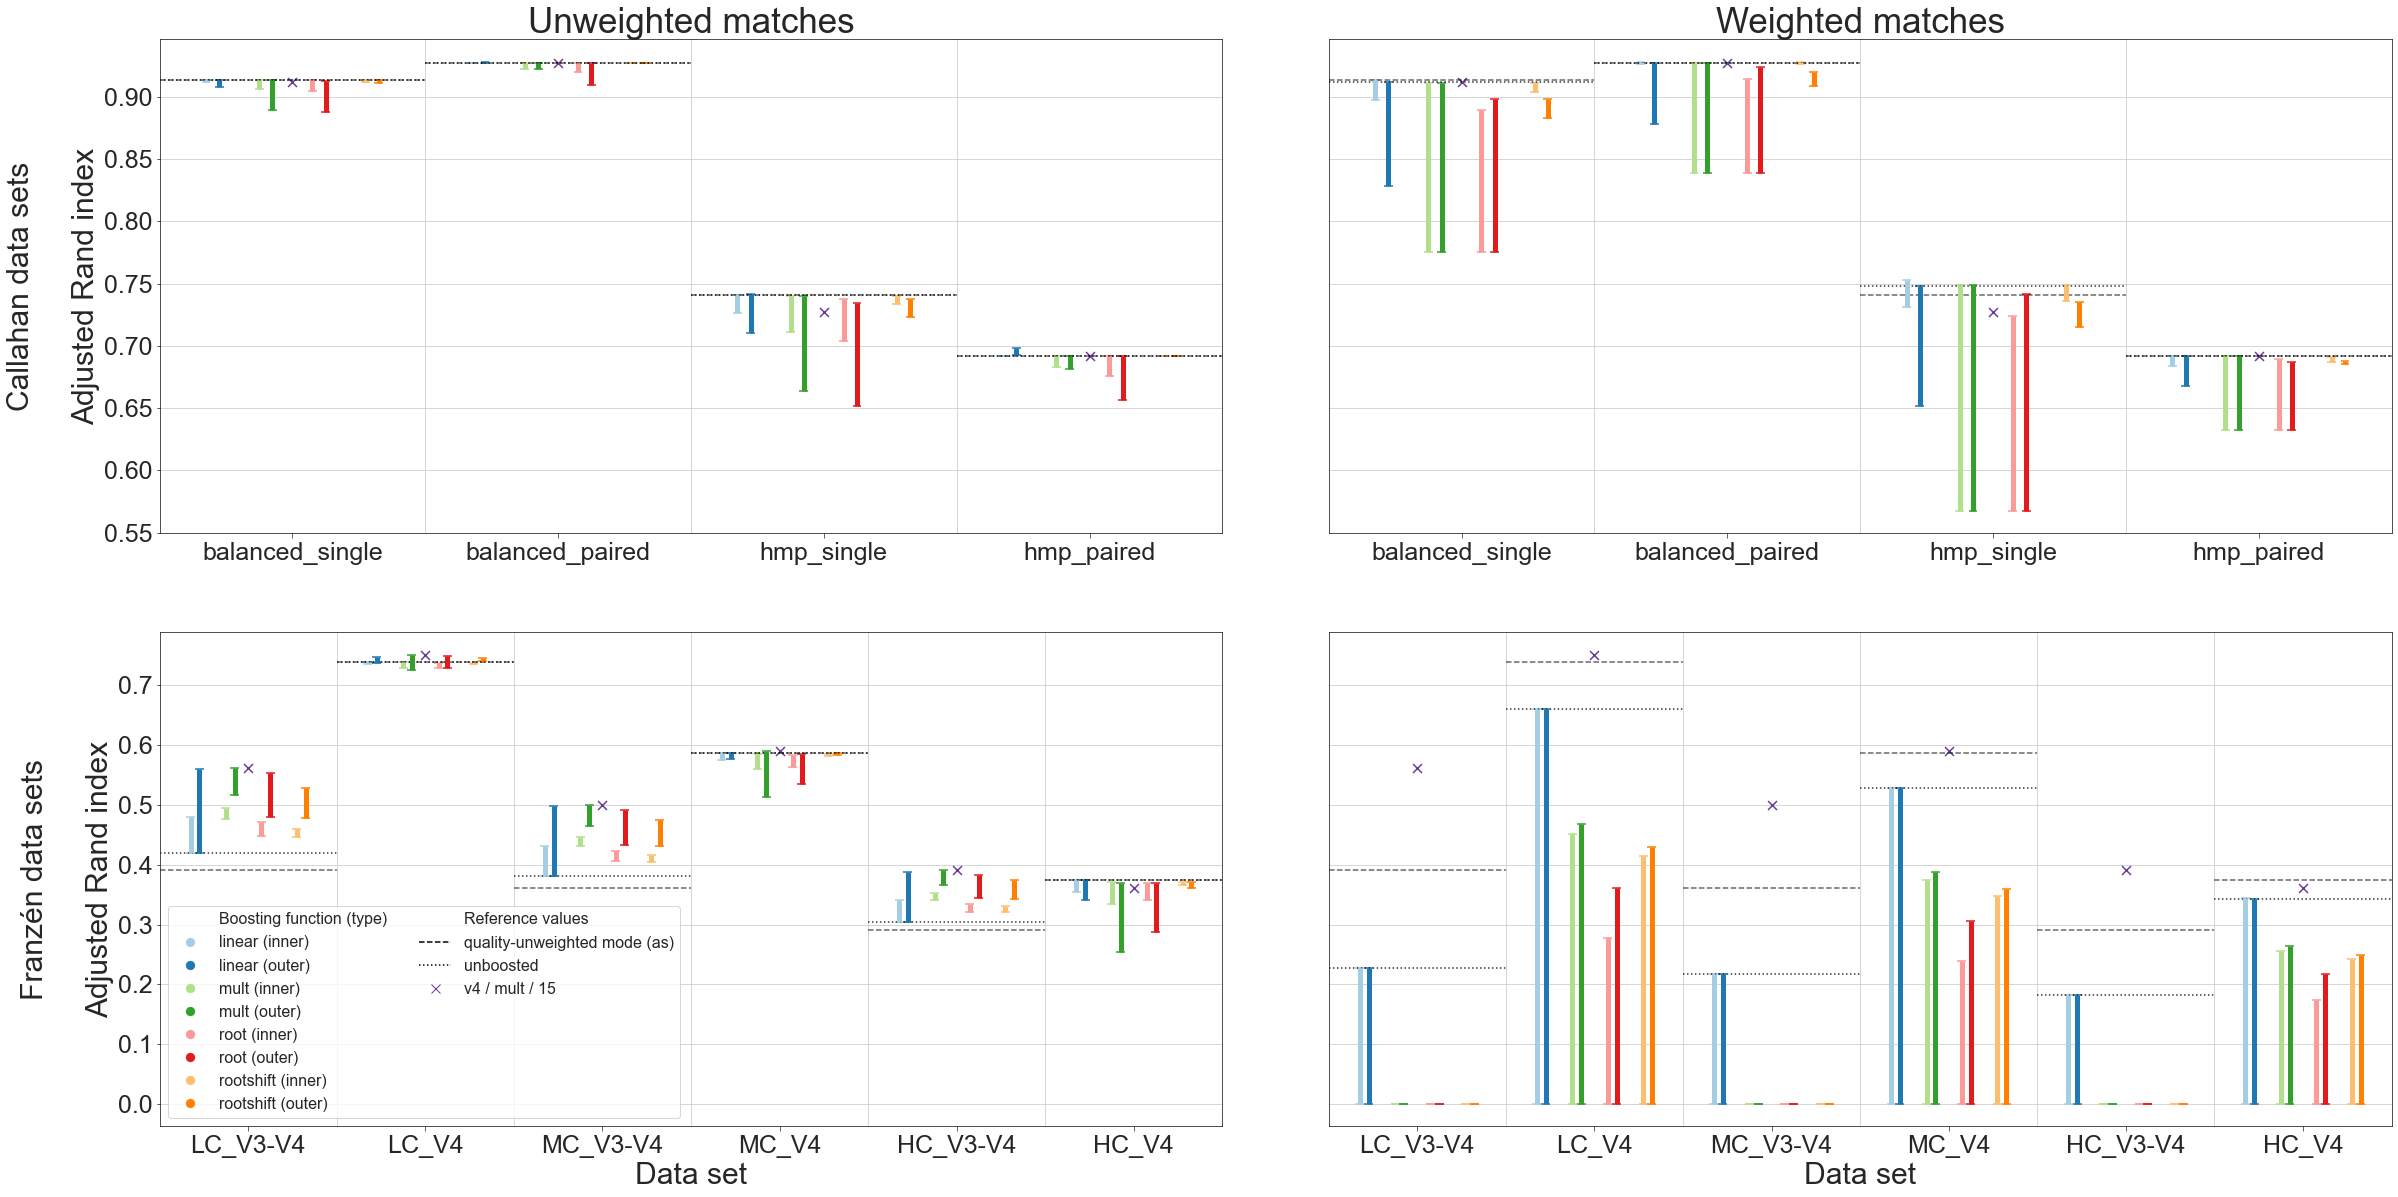

In [32]:
portions = [('Callahan data sets', df_callahan_gefast_joined_mean_avg, ['balanced_single', 'balanced_paired', 'hmp_single', 'hmp_paired']), 
            ('Franzén data sets', df_franzen_gefast_joined_mean_avg, ['LC_V3-V4', 'LC_V4', 'MC_V3-V4', 'MC_V4', 'HC_V3-V4', 'HC_V4'])]
modes = (mode, qmode)
metric = 'adjrandindex'
overview_plot(portions, modes, metric, qw_option, (best_v, best_b, best_bp))

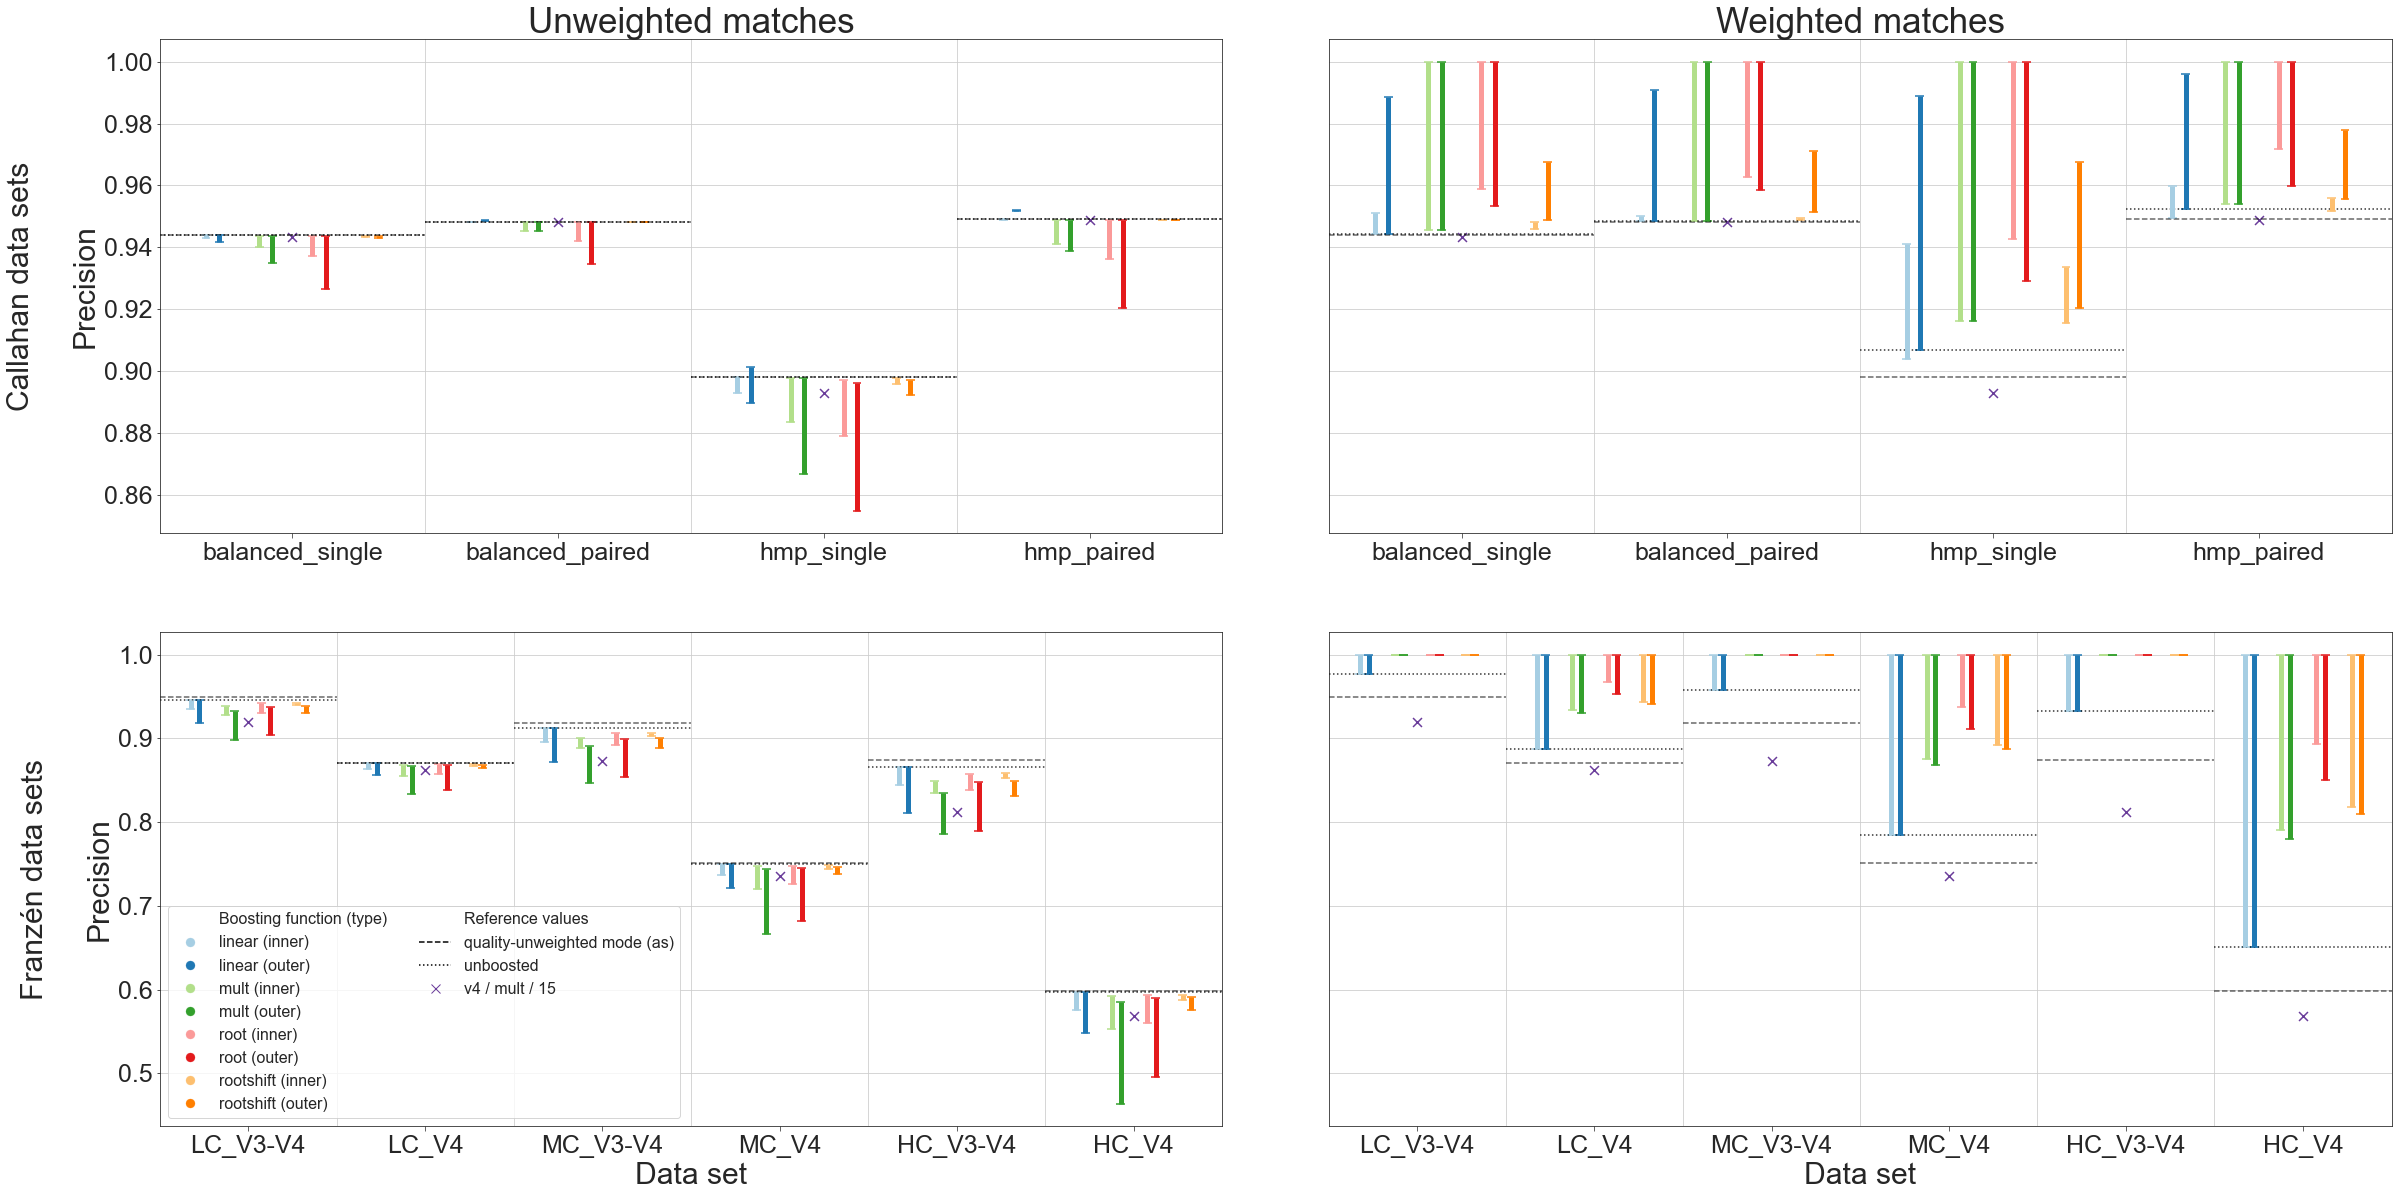

In [33]:
portions = [('Callahan data sets', df_callahan_gefast_joined_mean_avg, ['balanced_single', 'balanced_paired', 'hmp_single', 'hmp_paired']), 
            ('Franzén data sets', df_franzen_gefast_joined_mean_avg, ['LC_V3-V4', 'LC_V4', 'MC_V3-V4', 'MC_V4', 'HC_V3-V4', 'HC_V4'])]
modes = (mode, qmode)
metric = 'precision'
overview_plot(portions, modes, metric, qw_option, (best_v, best_b, best_bp))

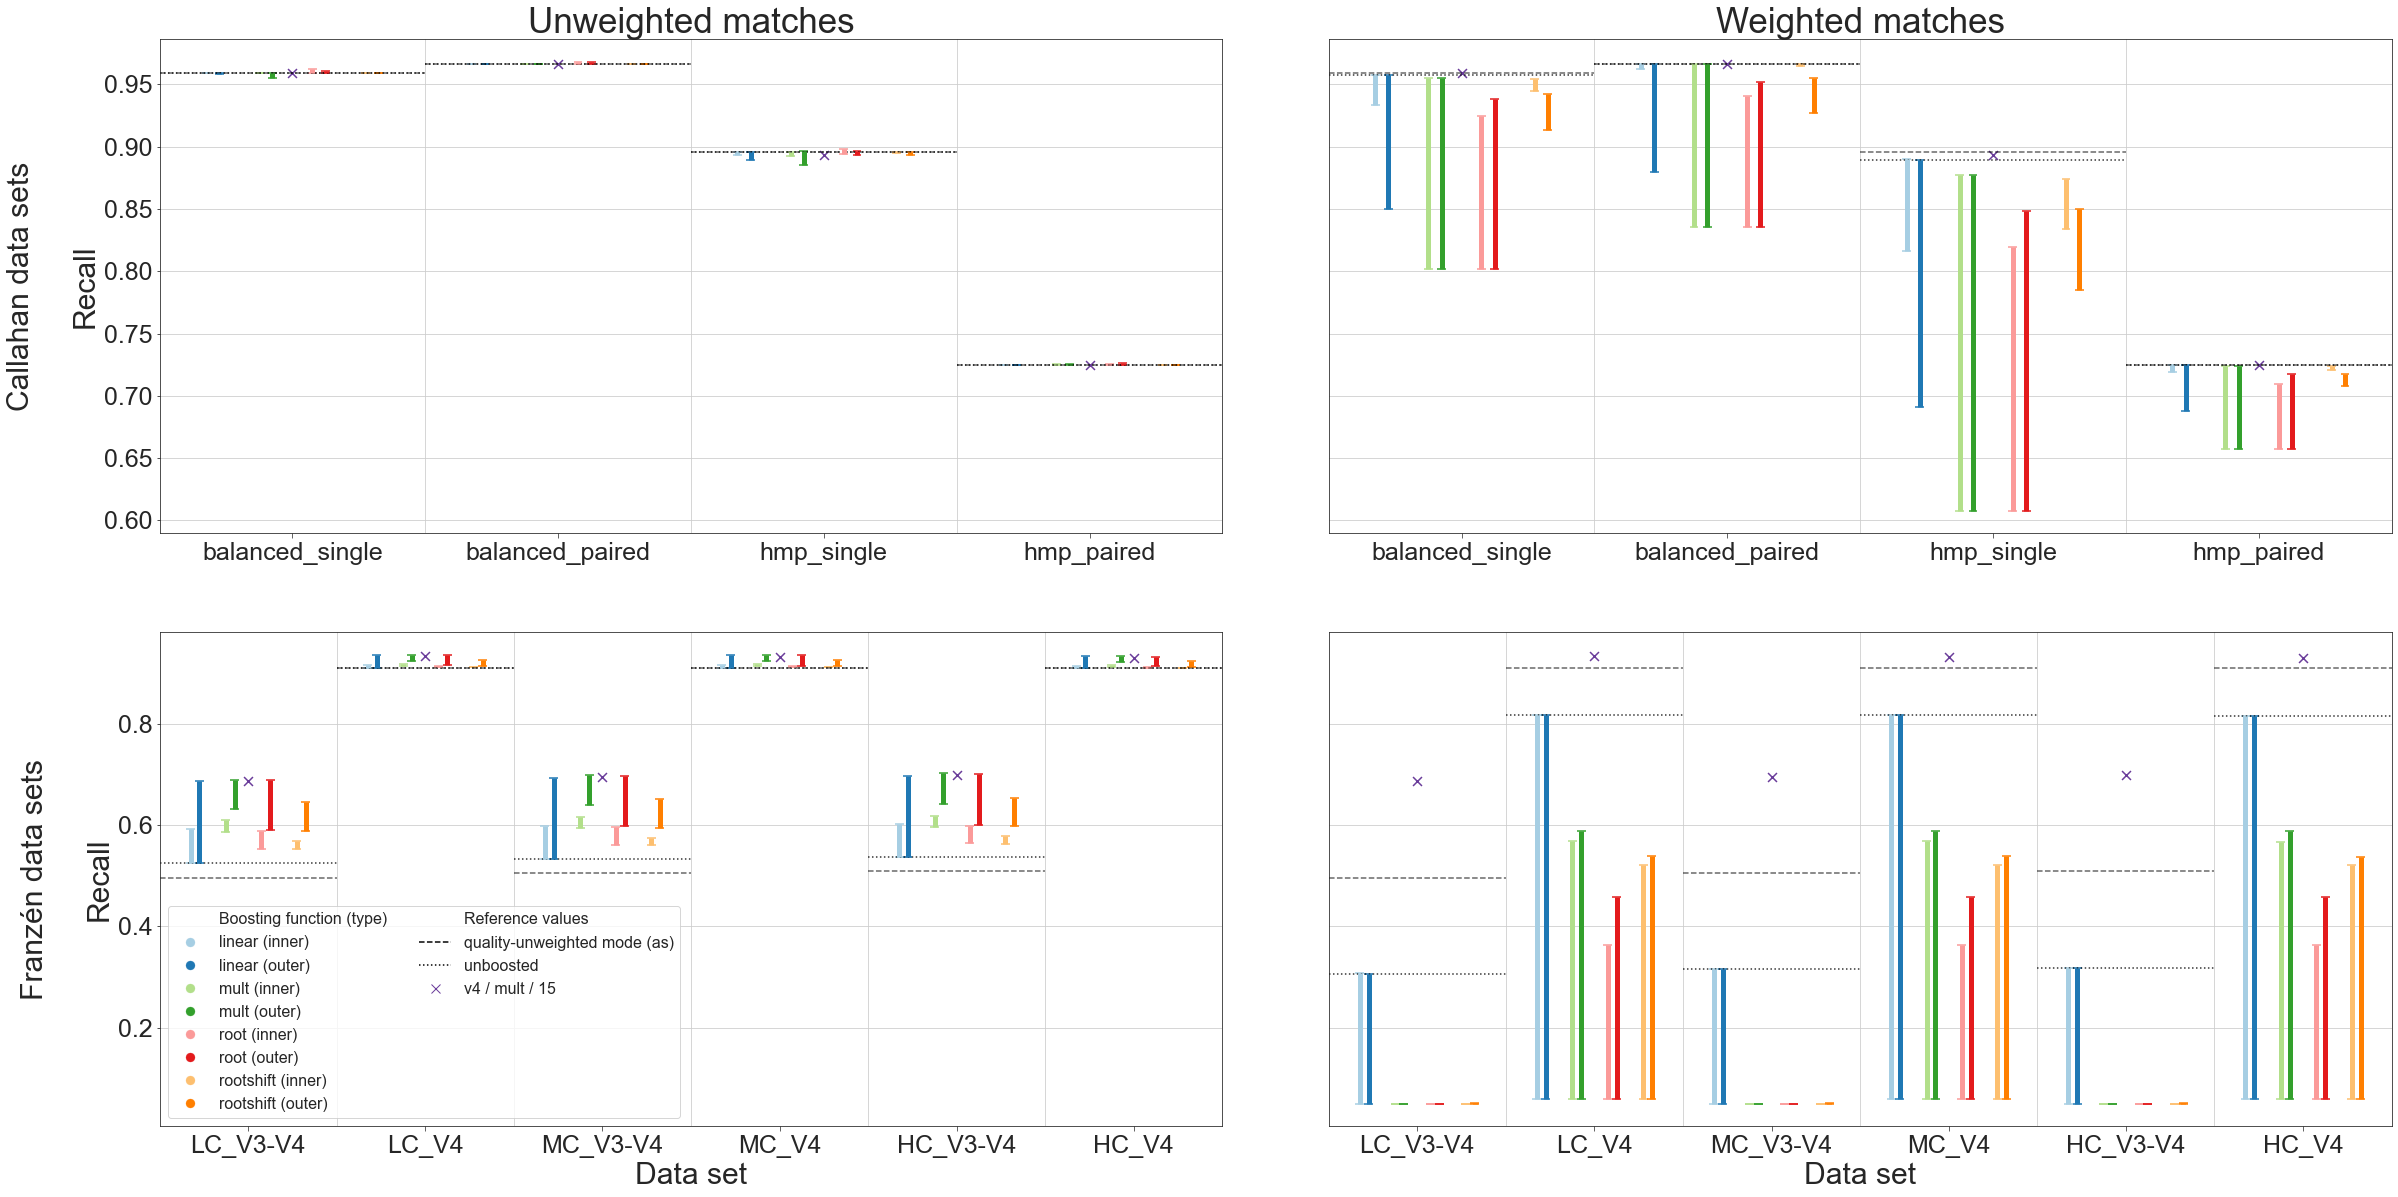

In [34]:
portions = [('Callahan data sets', df_callahan_gefast_joined_mean_avg, ['balanced_single', 'balanced_paired', 'hmp_single', 'hmp_paired']), 
            ('Franzén data sets', df_franzen_gefast_joined_mean_avg, ['LC_V3-V4', 'LC_V4', 'MC_V3-V4', 'MC_V4', 'HC_V3-V4', 'HC_V4'])]
modes = (mode, qmode)
metric = 'recall'
overview_plot(portions, modes, metric, qw_option, (best_v, best_b, best_bp))

For ARI, the overall tendencies were similar to maximum above. However, the different variants deviated more from each other.   
More pronounced difference between V3-V4 and V4.   
In contrast to maximum, the precision tended to be smaller, while the recall stayed the same or increased (especially on Franzén data (V3-V4)).

-- *N-best average clustering quality*

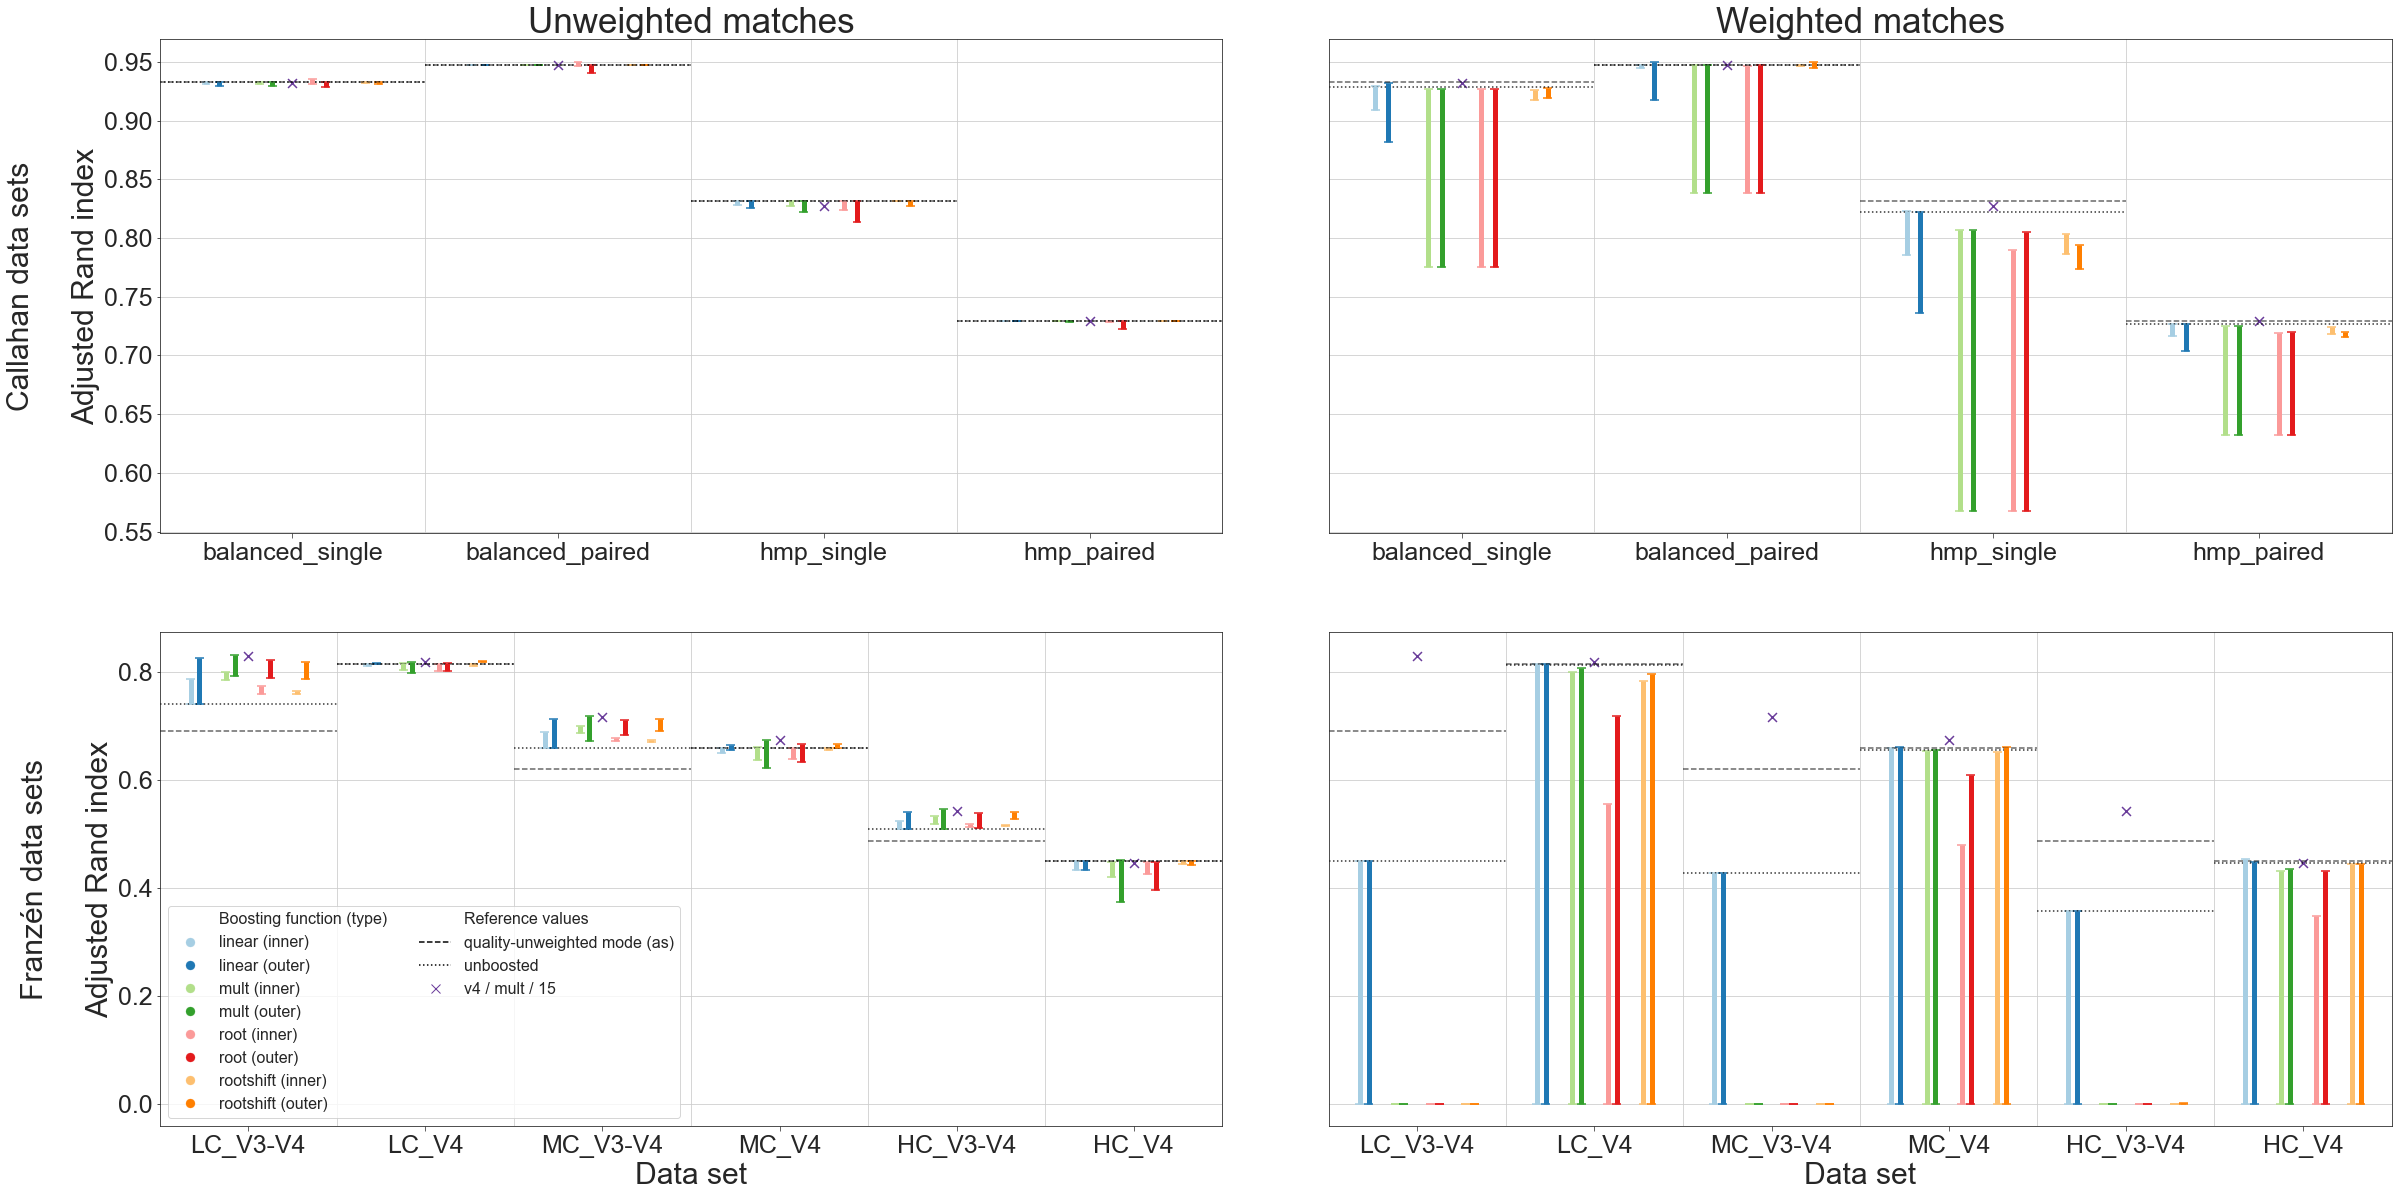

In [35]:
portions = [('Callahan data sets', df_callahan_gefast_joined_nbest_avg, ['balanced_single', 'balanced_paired', 'hmp_single', 'hmp_paired']), 
            ('Franzén data sets', df_franzen_gefast_joined_nbest_avg, ['LC_V3-V4', 'LC_V4', 'MC_V3-V4', 'MC_V4', 'HC_V3-V4', 'HC_V4'])]
modes = (mode, qmode)
metric = 'adjrandindex'
overview_plot(portions, modes, metric, qw_option, (best_v, best_b, best_bp))

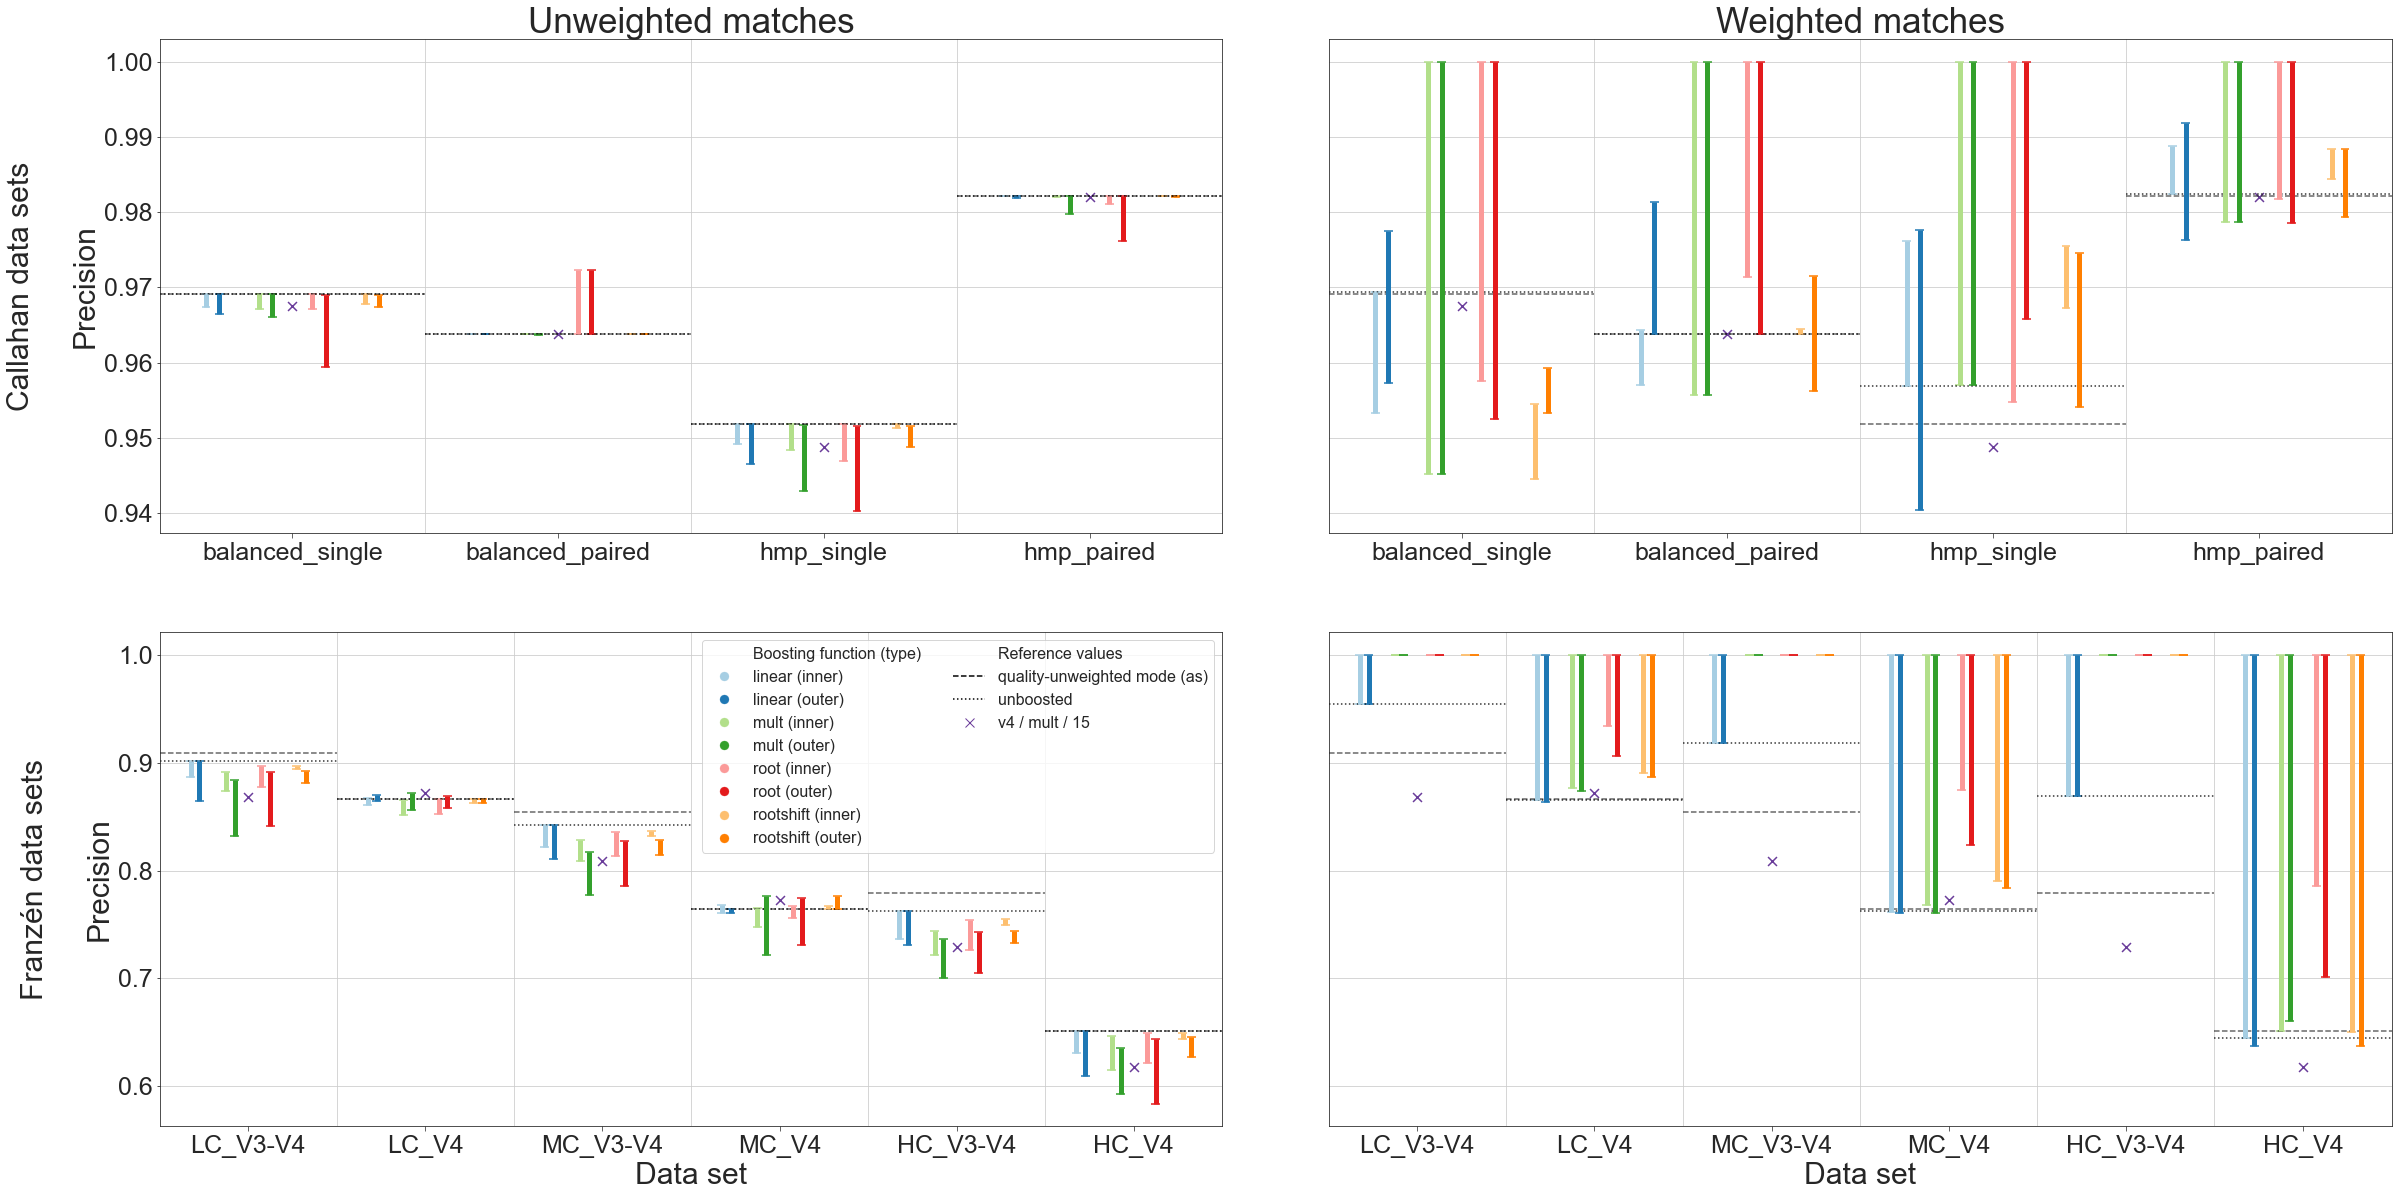

In [36]:
portions = [('Callahan data sets', df_callahan_gefast_joined_nbest_avg, ['balanced_single', 'balanced_paired', 'hmp_single', 'hmp_paired']), 
            ('Franzén data sets', df_franzen_gefast_joined_nbest_avg, ['LC_V3-V4', 'LC_V4', 'MC_V3-V4', 'MC_V4', 'HC_V3-V4', 'HC_V4'])]
modes = (mode, qmode)
metric = 'precision'
overview_plot(portions, modes, metric, qw_option, (best_v, best_b, best_bp))

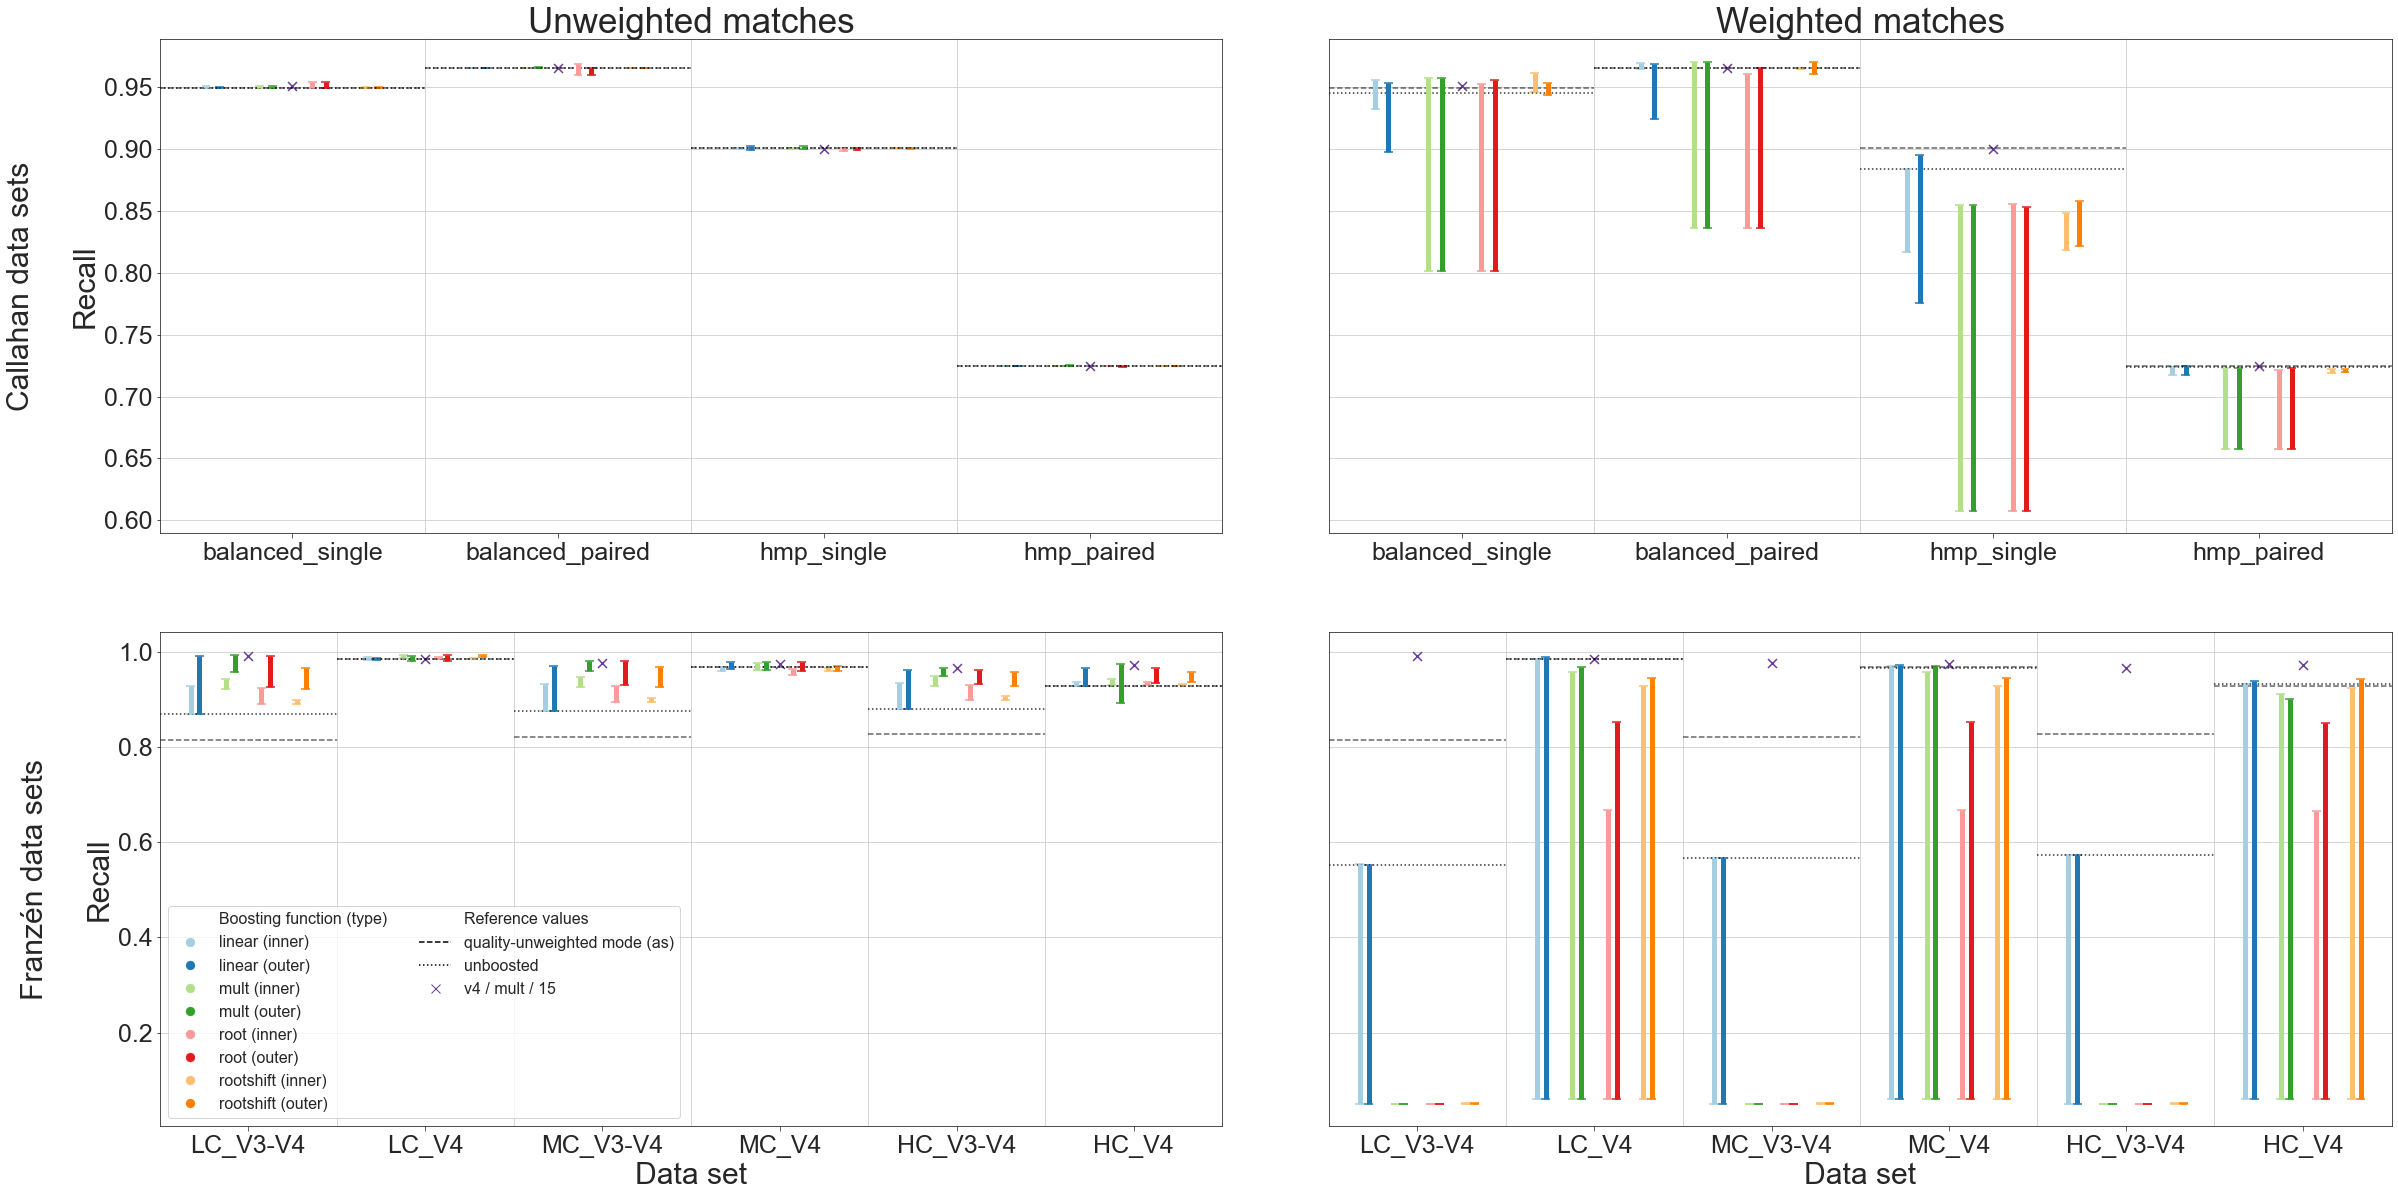

In [37]:
portions = [('Callahan data sets', df_callahan_gefast_joined_nbest_avg, ['balanced_single', 'balanced_paired', 'hmp_single', 'hmp_paired']), 
            ('Franzén data sets', df_franzen_gefast_joined_nbest_avg, ['LC_V3-V4', 'LC_V4', 'MC_V3-V4', 'MC_V4', 'HC_V3-V4', 'HC_V4'])]
modes = (mode, qmode)
metric = 'recall'
overview_plot(portions, modes, metric, qw_option, (best_v, best_b, best_bp))

The tendencies were very similar to average.

### Comparison with USEARCH and VSEARCH

Compares the clustering quality of the quality-unweighted mode, the best unboosted and boosted variant with USEARCH and VSEARCH.

In [38]:
def avg_diff_multiple_uvsearch(portions, ref, cmps, metric = 'adjrandindex'):
    
    ref_tool, ref_mode = ref
    
    df_columns = ['data_group'] + ['%s / %s / %s / %s / %s' % (m, v, q, b, bp) for m, v, q, b, bp in cmps]
    
    rows = []
    for ref_df, df, data_set_groups, gt in portions:
        for (name, dsg) in data_set_groups:            
            ref_grp = ref_df.loc[(ref_df['data_set'].isin(dsg)) & (ref_df['gt'] == gt) & (ref_df['tool'] == ref_tool) & (ref_df['mode'] == ref_mode)]
            
            row = [name]
            for mode, v, qw, b, bp in cmps:
                cmp_grp = df.loc[df['data_set'].isin(dsg) & (df['gt'] == gt) & (df['mode'] == mode) & (df['v_opt'] == v) & (df['qw_opt'] == qw) & (df['b_opt'] == b) & (df['b_param'] == bp)]
                
                row.append(cmp_grp[metric].mean() - ref_grp[metric].mean())
            
            rows.append(row)
            
    return pd.DataFrame(rows, columns = df_columns)

**USEARCH**

-- *Maximum clustering quality*

In [39]:
for m in ['adjrandindex', 'precision', 'recall']:
    print('%s:' % rename_map[m])
    display(avg_diff_multiple_uvsearch([(df_franzen_uvsearch_joined_max_avg, df_franzen_gefast_joined_max_avg, [('V3-V4', ['LC_V3-V4', 'MC_V3-V4', 'HC_V3-V4']), ('V4', ['LC_V4', 'MC_V4', 'HC_V4'])], 'franzen'),
                            (df_callahan_uvsearch_joined_max_avg, df_callahan_gefast_joined_max_avg, [('paired', ['balanced_paired', 'hmp_paired']), ('single', ['balanced_single', 'hmp_single'])], 'callahan')], 
                           ('usearch', 'fast_size'), [(mode, 'none', 'none', 'none', 'none'), (qmode, best_ub, qw_option, 'unboosted', 'none'), (qmode, best_v, qw_option, best_b, best_bp)], metric = m))

Adjusted Rand index:


,data_group,as / none / none / none / none,qas / muw / ca / unboosted / none,qas / v4 / ca / mult / 15
0,V3-V4,-0.064190,-0.059919,-0.019822
1,V4,-0.023718,-0.023661,-0.002288
2,paired,-0.094289,-0.094289,-0.094237
3,single,-0.036916,-0.036916,-0.036916


Precision:


,data_group,as / none / none / none / none,qas / muw / ca / unboosted / none,qas / v4 / ca / mult / 15
0,V3-V4,-0.056674,-0.031269,-0.027850
1,V4,-0.042260,-0.042321,-0.019929
2,paired,-0.002890,-0.002890,-0.002896
3,single,0.020997,0.020997,0.020997


Recall:


,data_group,as / none / none / none / none,qas / muw / ca / unboosted / none,qas / v4 / ca / mult / 15
0,V3-V4,0.052765,0.019410,0.059066
1,V4,0.043966,0.044079,0.041469
2,paired,-0.099254,-0.099254,-0.099232
3,single,-0.049375,-0.049375,-0.049375


-- *Average clustering quality*

In [40]:
for m in ['adjrandindex', 'precision', 'recall']:
    print('%s:' % rename_map[m])
    display(avg_diff_multiple_uvsearch([(df_franzen_uvsearch_joined_mean_avg, df_franzen_gefast_joined_mean_avg, [('V3-V4', ['LC_V3-V4', 'MC_V3-V4', 'HC_V3-V4']), ('V4', ['LC_V4', 'MC_V4', 'HC_V4'])], 'franzen'),
                                        (df_callahan_uvsearch_joined_mean_avg, df_callahan_gefast_joined_mean_avg, [('paired', ['balanced_paired', 'hmp_paired']), ('single', ['balanced_single', 'hmp_single'])], 'callahan')], 
                                       ('usearch', 'fast_size'), [(mode, 'none', 'none', 'none', 'none'), (qmode, best_ub, qw_option, 'unboosted', 'none'), (qmode, best_v, qw_option, best_b, best_bp)], metric = m))

Adjusted Rand index:


,data_group,as / none / none / none / none,qas / muw / ca / unboosted / none,qas / v4 / ca / mult / 15
0,V3-V4,-0.186784,-0.166057,-0.049891
1,V4,0.052288,0.051622,0.052363
2,paired,-0.019669,-0.019668,-0.019686
3,single,-0.008128,-0.008145,-0.015626


Precision:


,data_group,as / none / none / none / none,qas / muw / ca / unboosted / none,qas / v4 / ca / mult / 15
0,V3-V4,0.190128,0.183967,0.144210
1,V4,0.137068,0.136459,0.119365
2,paired,0.057505,0.057505,0.057393
3,single,0.018325,0.018311,0.015358


Recall:


,data_group,as / none / none / none / none,qas / muw / ca / unboosted / none,qas / v4 / ca / mult / 15
0,V3-V4,-0.356208,-0.327629,-0.166071
1,V4,-0.053380,-0.053324,-0.031598
2,paired,-0.110191,-0.110191,-0.110178
3,single,-0.023721,-0.023716,-0.025097


-- *N-best average clustering quality*

In [41]:
for m in ['adjrandindex', 'precision', 'recall']:
    print('%s:' % rename_map[m])
    display(avg_diff_multiple_uvsearch([(df_franzen_uvsearch_joined_nbest_avg, df_franzen_gefast_joined_nbest_avg, [('V3-V4', ['LC_V3-V4', 'MC_V3-V4', 'HC_V3-V4']), ('V4', ['LC_V4', 'MC_V4', 'HC_V4'])], 'franzen'),
                                        (df_callahan_uvsearch_joined_nbest_avg, df_callahan_gefast_joined_nbest_avg, [('paired', ['balanced_paired', 'hmp_paired']), ('single', ['balanced_single', 'hmp_single'])], 'callahan')], 
                                       ('usearch', 'fast_size'), [(mode, 'none', 'none', 'none', 'none'), (qmode, best_ub, qw_option, 'unboosted', 'none'), (qmode, best_v, qw_option, best_b, best_bp)], metric = m))

Adjusted Rand index:


,data_group,as / none / none / none / none,qas / muw / ca / unboosted / none,qas / v4 / ca / mult / 15
0,V3-V4,-0.057930,-0.019820,0.039845
1,V4,0.027684,0.027601,0.032955
2,paired,-0.075048,-0.075047,-0.075027
3,single,-0.036216,-0.036216,-0.039019


Precision:


,data_group,as / none / none / none / none,qas / muw / ca / unboosted / none,qas / v4 / ca / mult / 15
0,V3-V4,0.067788,0.055901,0.022173
1,V4,0.038201,0.037973,0.031507
2,paired,0.021963,0.021963,0.021946
3,single,0.000709,0.000709,-0.001621


Recall:


,data_group,as / none / none / none / none,qas / muw / ca / unboosted / none,qas / v4 / ca / mult / 15
0,V3-V4,-0.101097,-0.047459,0.056129
1,V4,0.007824,0.008019,0.024500
2,paired,-0.107197,-0.107197,-0.107177
3,single,-0.023558,-0.023558,-0.023200


USEARCH was at least slightly better in maximum quality on all categories (especially paired, mainly due to hmp_paired).   
The boosted variant, however, tended to be more robust on Franzén data (N-best).

**VSEARCH**

-- *Maximum clustering quality*

In [42]:
for m in ['adjrandindex', 'precision', 'recall']:
    print('%s:' % rename_map[m])
    display(avg_diff_multiple_uvsearch([(df_franzen_uvsearch_joined_max_avg, df_franzen_gefast_joined_max_avg, [('V3-V4', ['LC_V3-V4', 'MC_V3-V4', 'HC_V3-V4']), ('V4', ['LC_V4', 'MC_V4', 'HC_V4'])], 'franzen'),
                                        (df_callahan_uvsearch_joined_max_avg, df_callahan_gefast_joined_max_avg, [('paired', ['balanced_paired', 'hmp_paired']), ('single', ['balanced_single', 'hmp_single'])], 'callahan')], 
                                       ('vsearch', 'size'), [(mode, 'none', 'none', 'none', 'none'), (qmode, best_ub, qw_option, 'unboosted', 'none'), (qmode, best_v, qw_option, best_b, best_bp)], metric = m))

Adjusted Rand index:


,data_group,as / none / none / none / none,qas / muw / ca / unboosted / none,qas / v4 / ca / mult / 15
0,V3-V4,-0.083213,-0.078942,-0.038845
1,V4,-0.026403,-0.026346,-0.004973
2,paired,-0.103465,-0.103465,-0.103413
3,single,-0.041363,-0.041363,-0.041363


Precision:


,data_group,as / none / none / none / none,qas / muw / ca / unboosted / none,qas / v4 / ca / mult / 15
0,V3-V4,-0.066426,-0.041021,-0.037602
1,V4,-0.047916,-0.047977,-0.025585
2,paired,-0.003929,-0.003929,-0.003935
3,single,0.017938,0.017938,0.017938


Recall:


,data_group,as / none / none / none / none,qas / muw / ca / unboosted / none,qas / v4 / ca / mult / 15
0,V3-V4,0.031964,-0.001392,0.038264
1,V4,0.048739,0.048852,0.046242
2,paired,-0.108350,-0.108350,-0.108329
3,single,-0.048321,-0.048321,-0.048321


-- *Average clustering quality*

In [43]:
for m in ['adjrandindex', 'precision', 'recall']:
    print('%s:' % rename_map[m])
    display(avg_diff_multiple_uvsearch([(df_franzen_uvsearch_joined_mean_avg, df_franzen_gefast_joined_mean_avg, [('V3-V4', ['LC_V3-V4', 'MC_V3-V4', 'HC_V3-V4']), ('V4', ['LC_V4', 'MC_V4', 'HC_V4'])], 'franzen'),
                                        (df_callahan_uvsearch_joined_mean_avg, df_callahan_gefast_joined_mean_avg, [('paired', ['balanced_paired', 'hmp_paired']), ('single', ['balanced_single', 'hmp_single'])], 'callahan')], 
                                       ('vsearch', 'size'), [(mode, 'none', 'none', 'none', 'none'), (qmode, best_ub, qw_option, 'unboosted', 'none'), (qmode, best_v, qw_option, best_b, best_bp)], metric = m))

Adjusted Rand index:


,data_group,as / none / none / none / none,qas / muw / ca / unboosted / none,qas / v4 / ca / mult / 15
0,V3-V4,-0.196160,-0.175432,-0.059266
1,V4,0.052576,0.051910,0.052651
2,paired,-0.023934,-0.023933,-0.023951
3,single,-0.009641,-0.009658,-0.017139


Precision:


,data_group,as / none / none / none / none,qas / muw / ca / unboosted / none,qas / v4 / ca / mult / 15
0,V3-V4,0.188236,0.182075,0.142318
1,V4,0.139106,0.138497,0.121404
2,paired,0.057758,0.057758,0.057646
3,single,0.019458,0.019443,0.016490


Recall:


,data_group,as / none / none / none / none,qas / muw / ca / unboosted / none,qas / v4 / ca / mult / 15
0,V3-V4,-0.369810,-0.341231,-0.179674
1,V4,-0.055834,-0.055778,-0.034053
2,paired,-0.113542,-0.113542,-0.113529
3,single,-0.025427,-0.025423,-0.026803


-- *N-best average clustering quality*

In [44]:
for m in ['adjrandindex', 'precision', 'recall']:
    print('%s:' % rename_map[m])
    display(avg_diff_multiple_uvsearch([(df_franzen_uvsearch_joined_nbest_avg, df_franzen_gefast_joined_nbest_avg, [('V3-V4', ['LC_V3-V4', 'MC_V3-V4', 'HC_V3-V4']), ('V4', ['LC_V4', 'MC_V4', 'HC_V4'])], 'franzen'),
                                        (df_callahan_uvsearch_joined_nbest_avg, df_callahan_gefast_joined_nbest_avg, [('paired', ['balanced_paired', 'hmp_paired']), ('single', ['balanced_single', 'hmp_single'])], 'callahan')], 
                                       ('vsearch', 'size'), [(mode, 'none', 'none', 'none', 'none'), (qmode, best_ub, qw_option, 'unboosted', 'none'), (qmode, best_v, qw_option, best_b, best_bp)], metric = m))

Adjusted Rand index:


,data_group,as / none / none / none / none,qas / muw / ca / unboosted / none,qas / v4 / ca / mult / 15
0,V3-V4,-0.072352,-0.034241,0.025424
1,V4,0.022689,0.022607,0.027960
2,paired,-0.081592,-0.081592,-0.081572
3,single,-0.040588,-0.040588,-0.043392


Precision:


,data_group,as / none / none / none / none,qas / muw / ca / unboosted / none,qas / v4 / ca / mult / 15
0,V3-V4,0.057656,0.045769,0.012041
1,V4,0.033450,0.033222,0.026756
2,paired,0.021068,0.021068,0.021051
3,single,-0.000060,-0.000060,-0.002389


Recall:


,data_group,as / none / none / none / none,qas / muw / ca / unboosted / none,qas / v4 / ca / mult / 15
0,V3-V4,-0.113437,-0.059800,0.043789
1,V4,0.005524,0.005719,0.022200
2,paired,-0.113215,-0.113214,-0.113195
3,single,-0.025376,-0.025376,-0.025019


Similar to USEARCH.